<p style="font-size:36px"> Personalized cancer diagnosis </p>

In [1]:
## import all the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Miscellaneous
import re
import time
import warnings
warnings.filterwarnings("ignore")

from collections import Counter
from scipy.sparse import hstack
from nltk.corpus import stopwords

# Sklearn
from sklearn.preprocessing import normalize ## Scale input vectors to unit norm (vector length)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier  ## Need to install mlxtend
from sklearn.ensemble import VotingClassifier

from sklearn.calibration import CalibratedClassifierCV  ## Probability Caliberation

# Evaluation Metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss

In [2]:
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
data = pd.read_csv('training_variants')

In [4]:
data.shape

(3321, 4)

In [5]:
data.columns.values

array(['ID', 'Gene', 'Variation', 'Class'], dtype=object)

In [6]:
data.head(10)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4
5,5,CBL,V391I,4
6,6,CBL,V430M,5
7,7,CBL,Deletion,1
8,8,CBL,Y371H,4
9,9,CBL,C384R,4


In [7]:
# note the seprator in this file
data_text =pd.read_csv("training_text",sep="\|\|",engine="python",names=["ID","TEXT"],skiprows=1)

In [8]:
data_text.shape

(3321, 2)

In [9]:
data_text.columns.values

array(['ID', 'TEXT'], dtype=object)

In [10]:
data_text.head(10)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...
5,5,Oncogenic mutations in the monomeric Casitas B...
6,6,Oncogenic mutations in the monomeric Casitas B...
7,7,CBL is a negative regulator of activated recep...
8,8,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,Abstract Juvenile myelomonocytic leukemia (JM...


# Preprocessing of text
* Remove stopwords
* Replace all special characters by space
* Remove multiple spaces
* Lower casing

In [11]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text, index, column):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        data_text[column][index] = string

In [12]:
# text processing stage.
start_time = time.time()

for index, row in data_text[:10].iterrows():
    nlp_preprocessing(row['TEXT'], index, 'TEXT')

print('Time took for preprocessing the text :',time.time() - start_time, "seconds")

Time took for preprocessing the text : 0.1410384178161621 seconds


In [13]:
# Just make a visual confirmation of pre-processing
data_text.head(10)

,ID,TEXT
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...
5,5,oncogenic mutations monomeric casitas b lineag...
6,6,oncogenic mutations monomeric casitas b lineag...
7,7,cbl negative regulator activated receptor tyro...
8,8,abstract juvenile myelomonocytic leukemia jmml...
9,9,abstract juvenile myelomonocytic leukemia jmml...


#### Merging both gene_variations and text data based on ID

In [14]:
result = pd.merge(data, data_text,on='ID', how='left')
result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


#### Save the dataframe so as not to preprocess everytime

In [15]:
result.to_pickle("result_after_preprocessing")

#### Read the saved preprocessed dataframe

In [16]:
result = pd.read_pickle("result_after_preprocessing")

In [17]:
y_true = result['Class'].values

## Below we replace the spaces into uncerscore in the gene and variation features
## So that we have only one value for them
result.Gene      = result.Gene.str.replace('\s+', '_')
result.Variation = result.Variation.str.replace('\s+', '_')

result.head()

,ID,Gene,Variation,Class,TEXT
0,0,FAM58A,Truncating_Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [18]:
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, test_df, y_train, y_test = train_test_split(result, y_true, stratify=y_true, test_size=0.2)

# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
train_df, cv_df, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

Check the number of data points in train, cv and test sets

In [19]:
print('Number of data points in train data:', train_df.shape[0])
print('Number of data points in test data:', test_df.shape[0])
print('Number of data points in cross validation data:', cv_df.shape[0])

Number of data points in train data: 2124
Number of data points in test data: 665
Number of data points in cross validation data: 532


####  Distribution of y_i's in Train, Test and Cross Validation datasets

In [20]:
# pd.sort_index() will sort the output of "value_counts" based on index.
train_class_distribution = train_df['Class'].value_counts().sort_index()
test_class_distribution = test_df['Class'].value_counts().sort_index()
cv_class_distribution = cv_df['Class'].value_counts().sort_index()

Distribution in train set

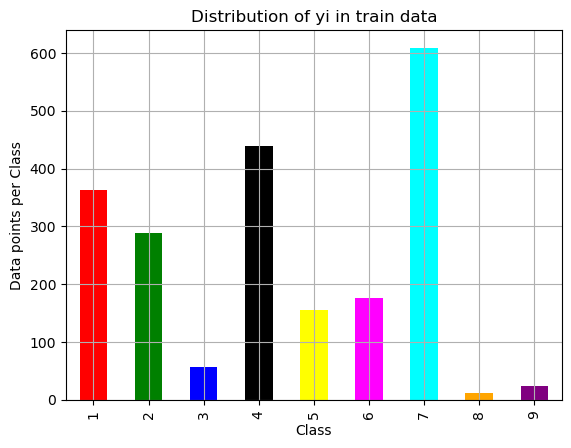

Number of data points in class 7 : 609 i.e. 28.672 %
Number of data points in class 4 : 439 i.e. 20.669 %
Number of data points in class 1 : 363 i.e. 17.09 %
Number of data points in class 2 : 289 i.e. 13.606 %
Number of data points in class 6 : 176 i.e. 8.286 %
Number of data points in class 5 : 155 i.e. 7.298 %
Number of data points in class 3 : 57 i.e. 2.684 %
Number of data points in class 9 : 24 i.e. 1.13 %
Number of data points in class 8 : 12 i.e. 0.565 %


In [21]:
train_class_distribution.plot(kind='bar', color=['red', 'green', 'blue', 'black', 'yellow', 'magenta', 'cyan', 'orange', 'purple'])

plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

## Print the distributions in the decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',train_class_distribution.values[i], 
          'i.e.', 
          np.round((train_class_distribution.values[i]/train_df.shape[0]*100), 3), 
          '%')

Distribution in test set

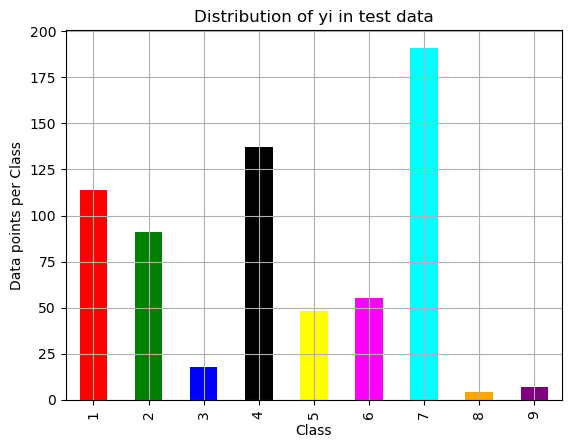

Number of data points in class 7 : 191 i.e. 28.722 %
Number of data points in class 4 : 137 i.e. 20.602 %
Number of data points in class 1 : 114 i.e. 17.143 %
Number of data points in class 2 : 91 i.e. 13.684 %
Number of data points in class 6 : 55 i.e. 8.271 %
Number of data points in class 5 : 48 i.e. 7.218 %
Number of data points in class 3 : 18 i.e. 2.707 %
Number of data points in class 9 : 7 i.e. 1.053 %
Number of data points in class 8 : 4 i.e. 0.602 %


In [22]:
test_class_distribution.plot(kind='bar',color=['red', 'green', 'blue', 'black', 'yellow', 'magenta', 'cyan', 'orange', 'purple'])
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

## Print the distributions in the decreasing order
sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',test_class_distribution.values[i], 
          'i.e.', 
          np.round((test_class_distribution.values[i]/test_df.shape[0]*100), 3),
          '%')

Distribution in cv set

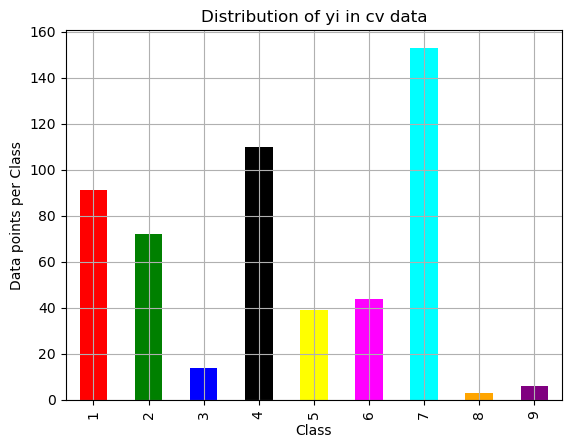

Number of data points in class 7 : 153 i.e. 28.759 %
Number of data points in class 4 : 110 i.e. 20.677 %
Number of data points in class 1 : 91 i.e. 17.105 %
Number of data points in class 2 : 72 i.e. 13.534 %
Number of data points in class 6 : 44 i.e. 8.271 %
Number of data points in class 5 : 39 i.e. 7.331 %
Number of data points in class 3 : 14 i.e. 2.632 %
Number of data points in class 9 : 6 i.e. 1.128 %
Number of data points in class 8 : 3 i.e. 0.564 %


In [23]:
cv_class_distribution.plot(kind='bar', color=['red', 'green', 'blue', 'black', 'yellow', 'magenta', 'cyan', 'orange', 'purple'])
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cv data')
plt.grid()
plt.show()

## Print the distributions in the decreasing order
sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i+1, ':',cv_class_distribution.values[i], 
          'i.e.', np.round((cv_class_distribution.values[i]/cv_df.shape[0]*100), 3), 
          '%')

#### Note: Due to stratification, the distributions of all classes are almost similar in all the 3 sets

##  Prediction using a 'Random' Model
In a 'Random' Model, we generate the NINE class probabilites randomly such that they sum to 1.

#### Below function is a utility function to print confusion, precision and recall matrices using heatmaps

In [24]:
def plot_confusion_matrix(test_y, predict_y):
    '''
    Inputs:
        1. test_y => Array of actual class of the train/cv/test points
        2. predict_y => Array of predicted class of the train/cv/test points
        
    Output:
        Function prints the confusion matrix, precision matrix and recall matrix using heatmaps
        Reference "https://seaborn.pydata.org/generated/seaborn.heatmap.html"
    '''
    labels = [1,2,3,4,5,6,7,8,9]
    
    ## Calculate the Confusion Matrix
    C = confusion_matrix(test_y, predict_y)
    
    ## Print Confusion Matrix using heatmap
    print("-"*20, "Confusion matrix", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    ## Calculate the Precision Matrix
    ## Divide each element of the confusion matrix with the sum of elements in that column
    A = C/C.sum(axis=0)
    
    ## Print Precision matrix using heatmap
    print("-"*20, "Precision matrix (Column Sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(A, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    ## Calculate the Recall Matrix
    ## Divide each element of the confusion matrix with the sum of elements in that row
    B = ((C.T)/(C.sum(axis=1))).T
    
    ## Print Recall matrix using heatmap
    print("-"*20, "Recall matrix (Row sum=1)", "-"*20)
    plt.figure(figsize=(20,7))
    sns.heatmap(B, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

#### Building a Random Model - For Hypothesis Testing
* We need to generate 9 numbers such that they sum to 1.
* One solution is to genarate 9 numbers and divide each of the numbers by their sum.

Log loss on Test Data using Random Model 2.4894062229776823
-------------------- Confusion matrix --------------------


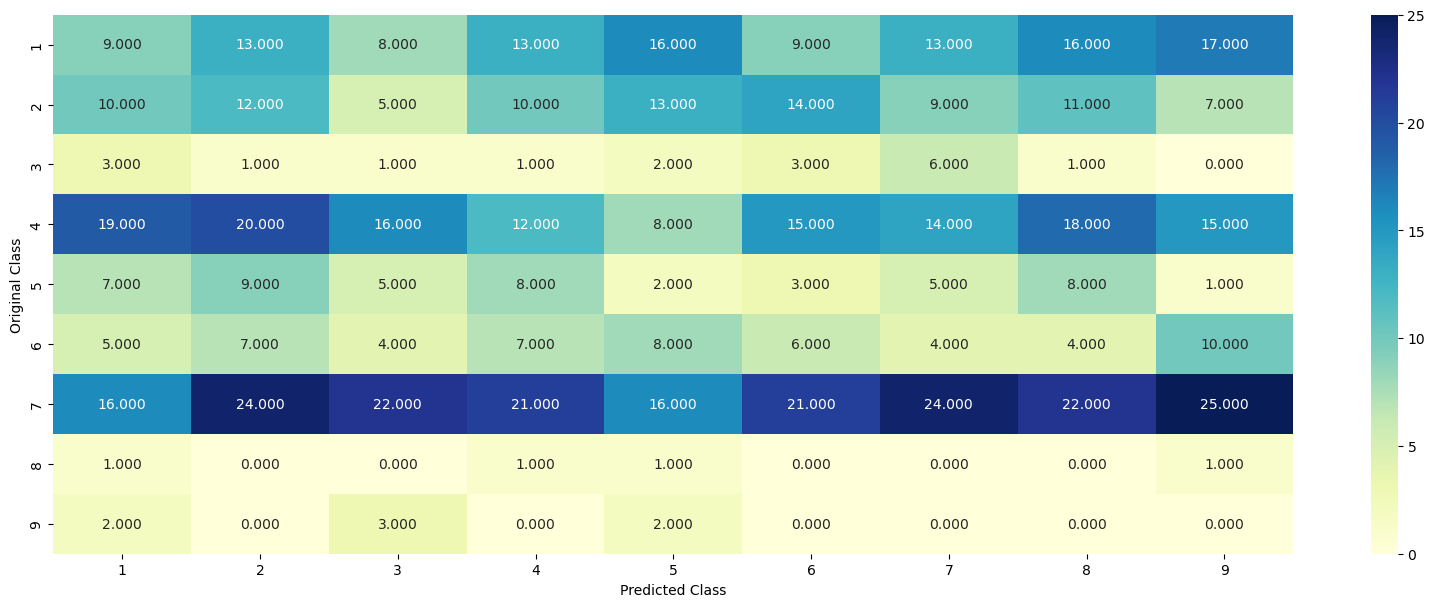

-------------------- Precision matrix (Column Sum=1) --------------------


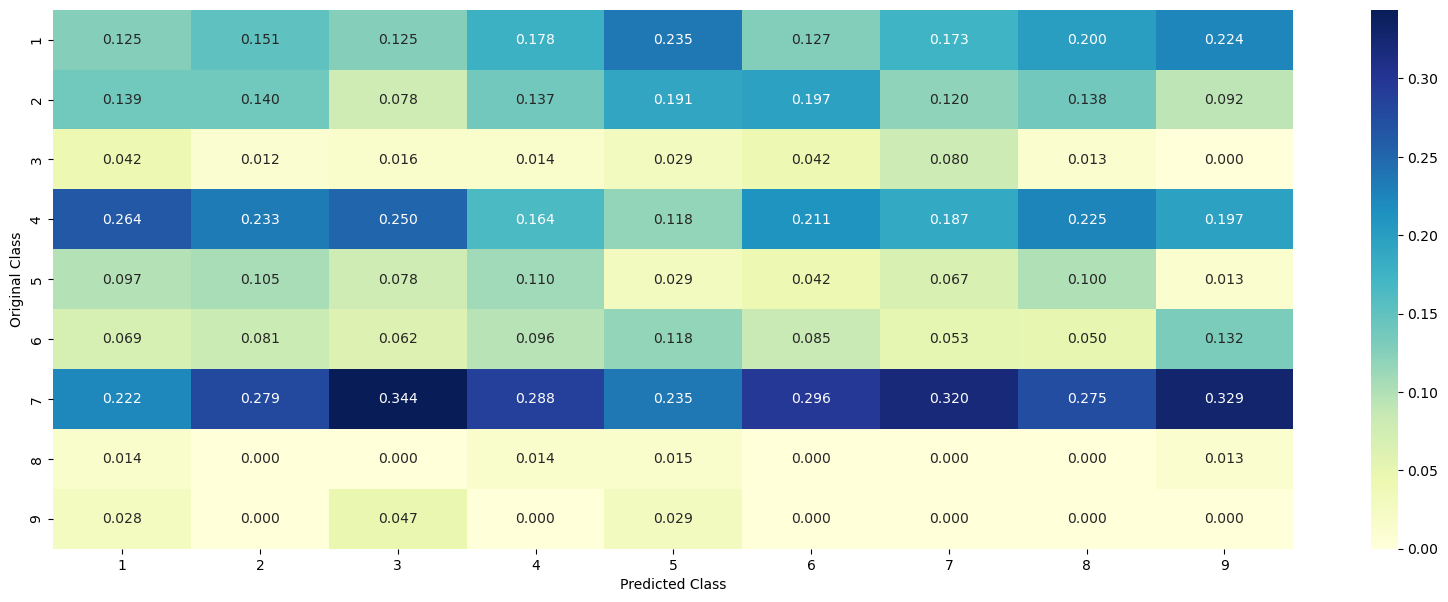

-------------------- Recall matrix (Row sum=1) --------------------


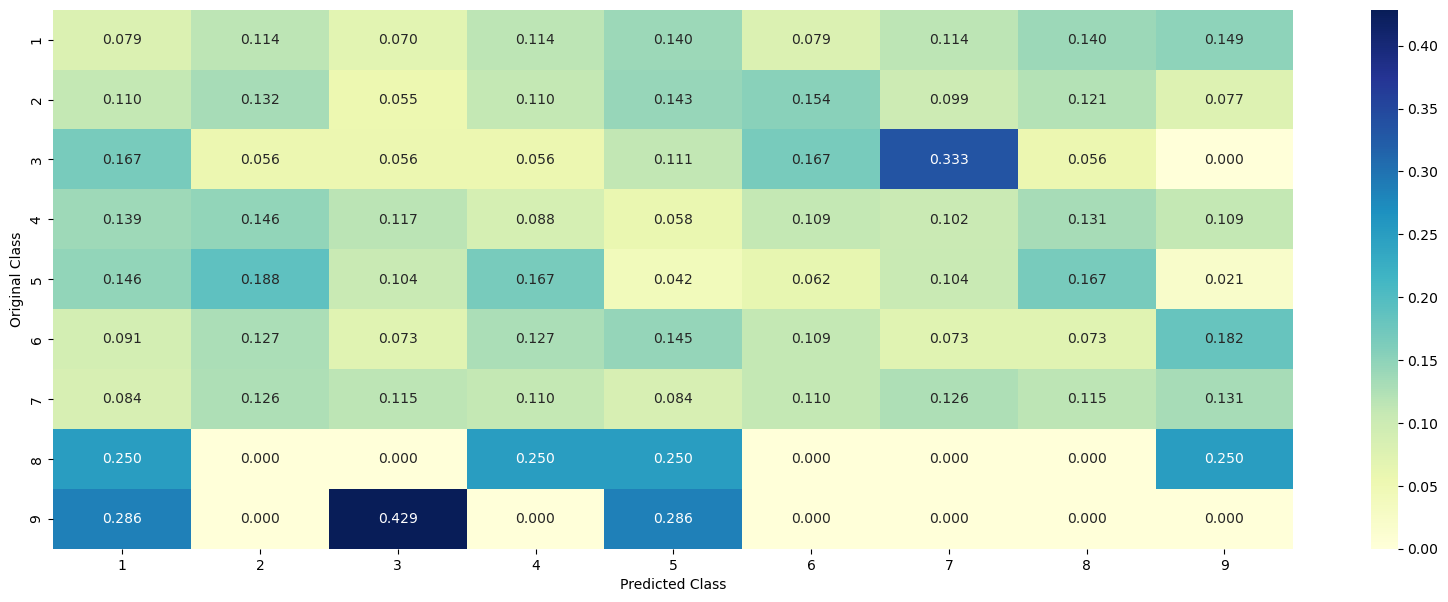

In [25]:
test_data_len = test_df.shape[0]

## Test-Set error.
## Create a output array that has exactly same as the test data
## For each point, generate a vector of size 9
test_predicted_y = np.zeros((test_data_len,9))

for i in range(test_data_len):
    rand_probs = np.random.rand(9)  # Generate 9 values between 0 and 1
    test_predicted_y[i] = rand_probs/sum(rand_probs)  # Divide each value by the sum
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y))


predicted_y = np.argmax(test_predicted_y, axis=1) # Predicted class is the one with highest probability
plot_confusion_matrix(y_test, predicted_y+1)  # +1 because index starts from 0 but classes are 1 to 9

##  Univariate Analysis

In [26]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes :', unique_genes.shape[0])
# the top 10 genes that occured most
print(unique_genes.head(10))

Number of Unique Genes : 235
BRCA1     166
TP53      104
EGFR       91
PTEN       90
BRCA2      72
BRAF       61
KIT        61
ERBB2      42
ALK        41
PDGFRA     39
Name: Gene, dtype: int64


In [27]:
print("Ans: There are", unique_genes.shape[0] ,"different categories of genes in the train data, and they are distibuted as follows",)

Ans: There are 235 different categories of genes in the train data, and they are distibuted as follows


##### Plotting the histogram for the distribution of genes

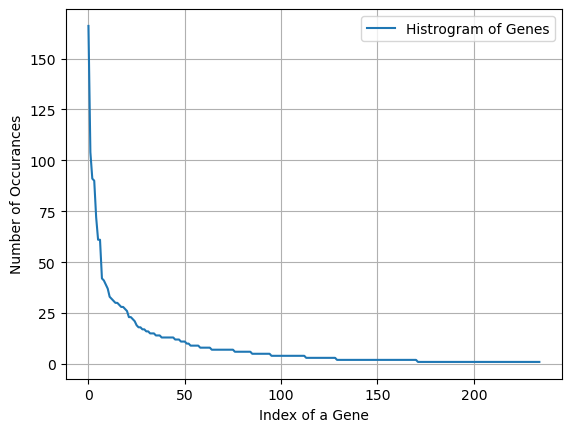

In [28]:
s = unique_genes.values
plt.plot(s, label="Histrogram of Genes")
plt.xlabel('Index of a Gene')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()

**Observation:** It is a skewed distribution

##### Plotting the CDF below

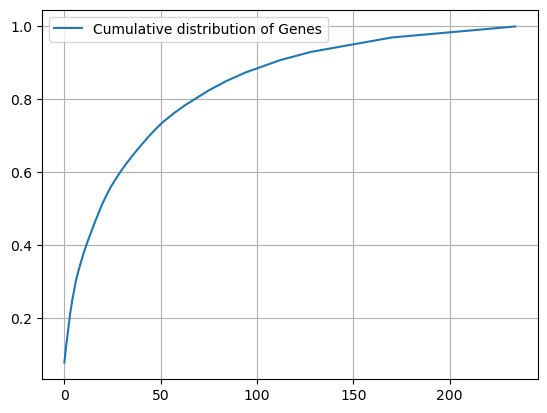

In [29]:
c = np.cumsum(s/sum(s))
plt.plot(c,label='Cumulative distribution of Genes')
plt.grid()
plt.legend()

**Observation:** Top 50 genes contribute to almost 75% of the data.

##### One-hot encoding of Gene feature (using CountVectorizer)

In [30]:
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(cv_df['Gene'])

In [31]:
print("train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature:", train_gene_feature_onehotCoding.shape)

train_gene_feature_onehotCoding is converted feature using one-hot encoding method. The shape of gene feature: (2124, 235)


##### Building a logistic regression model with only "gene"(with one-hot encoding) as the feature

In [32]:
alpha = [10 ** x for x in range(-5, 1)] ## hyperparameter for SGD classifier

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The cv log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

For values of alpha =  1e-05 The cv log loss is: 1.1972124396455315
For values of alpha =  0.0001 The cv log loss is: 1.1800520262090612
For values of alpha =  0.001 The cv log loss is: 1.2241013713425837
For values of alpha =  0.01 The cv log loss is: 1.3269656355401998
For values of alpha =  0.1 The cv log loss is: 1.4107125526772752
For values of alpha =  1 The cv log loss is: 1.4452498207936952


Using annotation below, otherwise the reading is very difficult.

Later we will use the log-scale which will make it even more readable

Text(0, 0.5, 'Error measure')

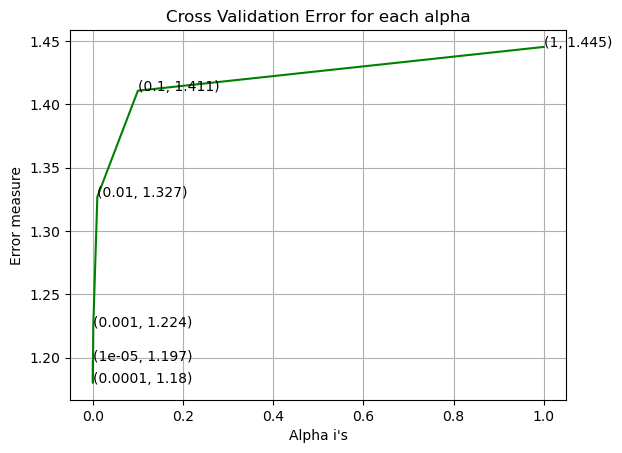

In [33]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

Building the model with the optimal hyperparameter and calculating: train, cv and test log loss

In [34]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

For values of best alpha =  0.0001 The train log loss is: 0.9848925772285779
For values of best alpha =  0.0001 The cross validation log loss is: 1.1773748618478947
For values of best alpha =  0.0001 The test log loss is: 1.1901127415727333


##### Testing the stability

In [35]:
print("data points in Test and CV datasets are covered by the ", unique_genes.shape[0], " genes in train dataset")

test_coverage=test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage=cv_df[cv_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

print('Ans\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

data points in Test and CV datasets are covered by the  235  genes in train dataset
Ans
1. In test data 643 out of 665 : 96.69172932330827
2. In cross validation data 517 out of  532 : 97.18045112781954


In [36]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# the top 10 variations that occured most
print(unique_variations.head(10))

Number of Unique Variations : 1931
Truncating_Mutations    60
Deletion                49
Amplification           48
Fusions                 21
Overexpression           4
E330K                    2
E17K                     2
Q61H                     2
G35R                     2
G13V                     2
Name: Variation, dtype: int64


In [37]:
print("There are", unique_variations.shape[0] ,"different categories of variations in the train data, and they are distibuted as follows",)

There are 1931 different categories of variations in the train data, and they are distibuted as follows


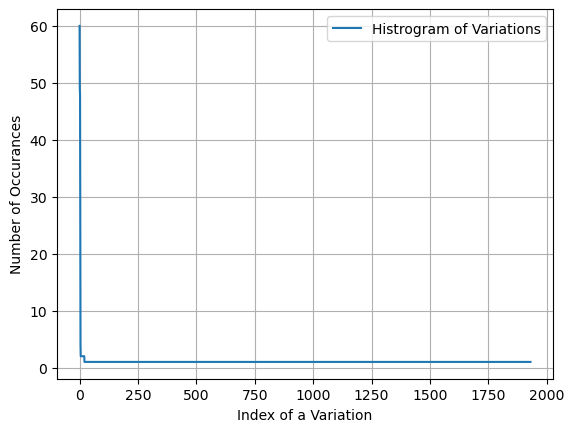

In [38]:
s = unique_variations.values
plt.plot(s, label="Histrogram of Variations")
plt.xlabel('Index of a Variation')
plt.ylabel('Number of Occurances')
plt.legend()
plt.grid()

**Observation:** Most of the data points have the variation value which is unique

[0.02824859 0.05131827 0.07391714 ... 0.99905838 0.99952919 1.        ]


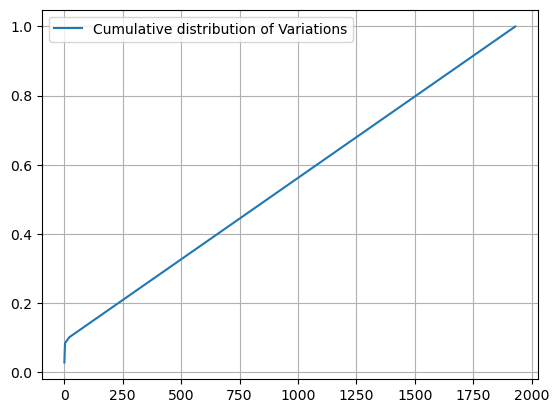

In [39]:
c = np.cumsum(s/sum(s))
print(c)
plt.plot(c,label='Cumulative distribution of Variations')
plt.grid()
plt.legend()
plt.show()

##### One-hot encoding of Variation feature (using CountVectorizer)

In [40]:
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(cv_df['Variation'])

In [41]:
print("train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature:", train_variation_feature_onehotCoding.shape)

train_variation_feature_onehotEncoded is converted feature using the one-hot encoding method. The shape of Variation feature: (2124, 1965)


In [42]:
alpha = [10 ** x for x in range(-5, 1)]  ## Hyperparameter tuning

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(train_variation_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_variation_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))

For values of alpha =  1e-05 The log loss is: 1.7113065084488381
For values of alpha =  0.0001 The log loss is: 1.6971202524219573
For values of alpha =  0.001 The log loss is: 1.6999307158061874
For values of alpha =  0.01 The log loss is: 1.7066637586247153
For values of alpha =  0.1 The log loss is: 1.7195072251369565
For values of alpha =  1 The log loss is: 1.7220121505860688


Text(0, 0.5, 'Error measure')

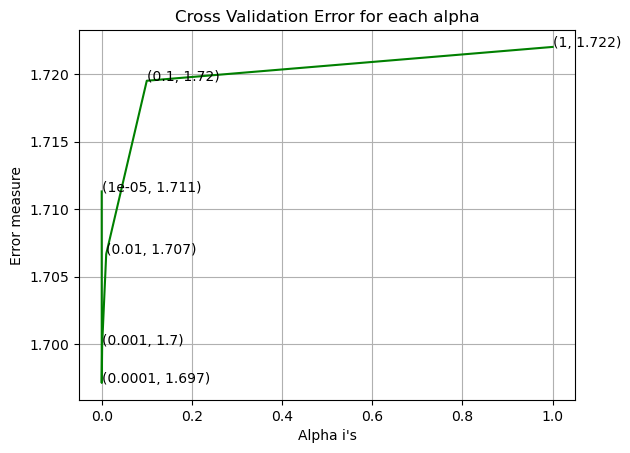

In [43]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

Building the model with the optimal hyperparameter and calculating: train, cv and test log loss

In [44]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_variation_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.0001 The train log loss is: 0.6984755683766515
For values of best alpha =  0.0001 The cross validation log loss is: 1.7001717994580847
For values of best alpha =  0.0001 The test log loss is: 1.7016922989317051


Q11. Is the Variation feature stable across all the data sets (Test, Train, Cross validation)?

Ans. Not sure! But lets be very sure using the below analysis.

In [45]:
print("Data points are covered by total ", unique_variations.shape[0], " genes in test and cross validation data sets?")

test_coverage=test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage=cv_df[cv_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

print('\n1. In test data',test_coverage, 'out of',test_df.shape[0], ":",(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data',cv_coverage, 'out of ',cv_df.shape[0],":" ,(cv_coverage/cv_df.shape[0])*100)

Data points are covered by total  1931  genes in test and cross validation data sets?

1. In test data 71 out of 665 : 10.676691729323307
2. In cross validation data 56 out of  532 : 10.526315789473683


## Univariate Analysis on Text Feature

1. Number of unique words are present in train data
2. word frequencies distributed
3. featurize text field
4. Is the text feature useful in predicitng y_i
5. Is the text feature stable across train, test and CV datasets

##### One-hot encoding for TEXT feature

In [46]:
from sklearn.feature_extraction.text import CountVectorizer

# Convert all elements in 'TEXT' column to strings
train_df['TEXT'] = train_df['TEXT'].astype(str)

# Initialize CountVectorizer with minimum document frequency of 3
text_vectorizer = CountVectorizer(min_df=3)

# Fit and transform the text data
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])

# Get feature names
train_text_features = text_vectorizer.get_feature_names()

# Sum up the occurrences of each feature
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

# Create a dictionary mapping words to their counts
text_fea_dict = dict(zip(train_text_features, train_text_fea_counts))

print("Total number of unique words in train data:", len(train_text_features))


Total number of unique words in train data: 54490


##### Normalizing every feature
Refer: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

This is the same normalization that we do for every column to bring each value in the scale of 0 to 1

In [47]:
from sklearn.preprocessing import normalize

# Convert all elements in text columns to strings
train_df['TEXT'] = train_df['TEXT'].astype(str)
test_df['TEXT'] = test_df['TEXT'].astype(str)
cv_df['TEXT'] = cv_df['TEXT'].astype(str)

# Normalize every feature in the train data
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# Transform and normalize text features for test and cross-validation data
test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(cv_df['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)


##### Checking the distribution of words

In [48]:
## Reference => https://stackoverflow.com/a/2258273/4084039
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key=lambda x: x[1] , reverse=True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

**Note:**

**sorted_text_fea_dict** is similar to text_fea_dict, but is sorted on values.

** sorted_text_occur** is an array of the values of sorted_text_fea_dict

In [49]:
# Number of words for a given frequency.
print(Counter(sorted_text_occur))

Counter({3: 5381, 4: 3980, 6: 3126, 5: 3000, 7: 2209, 8: 2132, 9: 1805, 12: 1505, 10: 1320, 14: 1184, 16: 998, 11: 925, 13: 843, 15: 765, 18: 701, 17: 603, 19: 569, 20: 549, 24: 534, 21: 499, 22: 423, 23: 401, 28: 399, 26: 382, 27: 363, 25: 357, 40: 351, 29: 344, 33: 326, 32: 314, 30: 303, 36: 288, 53: 269, 35: 255, 42: 246, 31: 241, 34: 230, 38: 212, 37: 204, 48: 192, 39: 186, 45: 184, 44: 176, 41: 166, 54: 163, 43: 159, 50: 156, 55: 153, 46: 149, 49: 145, 56: 139, 47: 139, 58: 132, 57: 131, 60: 130, 61: 128, 52: 126, 84: 124, 51: 121, 66: 120, 64: 117, 63: 113, 62: 112, 67: 110, 59: 105, 72: 99, 65: 99, 68: 98, 69: 97, 75: 94, 70: 88, 79: 87, 76: 87, 80: 82, 73: 82, 71: 82, 81: 79, 78: 78, 74: 75, 96: 71, 91: 70, 95: 69, 85: 69, 77: 69, 83: 68, 90: 67, 82: 66, 112: 65, 106: 65, 94: 65, 92: 62, 120: 60, 98: 60, 93: 60, 100: 59, 104: 58, 99: 58, 97: 58, 87: 58, 101: 56, 86: 55, 103: 54, 102: 54, 88: 54, 89: 52, 111: 51, 130: 50, 121: 49, 105: 49, 110: 48, 113: 47, 132: 45, 116: 45, 108

**Explanation:** This means there are 5472 words which occur 3 times; 3681 words which occur 4 times and so on ...

##### Training a Logistic Regression with only TEXT (one-hot encoded) as the feature

In [50]:
alpha = [10 ** x for x in range(-5, 1)]

cv_log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.33624979568939
For values of alpha =  0.0001 The log loss is: 1.2127050146702665
For values of alpha =  0.001 The log loss is: 1.1932698981179513
For values of alpha =  0.01 The log loss is: 1.2768165333936334
For values of alpha =  0.1 The log loss is: 1.4294731796300169
For values of alpha =  1 The log loss is: 1.6489332420106202


Text(0, 0.5, 'Error measure')

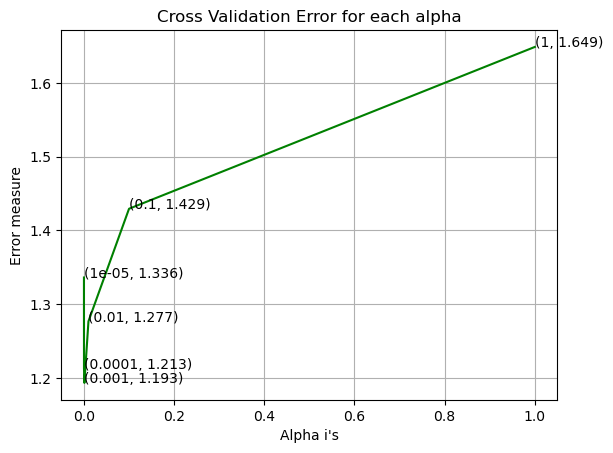

In [53]:
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [54]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_text_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_text_feature_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_text_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))


For values of best alpha =  0.001 The train log loss is: 0.6715488977669224
For values of best alpha =  0.001 The cross validation log loss is: 1.188741002695809
For values of best alpha =  0.001 The test log loss is: 1.1340472452244224


Text feature stable across all the data sets (Test, Train, Cross validation)

In [55]:
def get_intersec_text(df):
    '''
       Function takes dataframe "df" as input (either cv dataframe or test dataframe)
       It returns the number of words common in df and training dataset
       Note: "train_text_features" is already computed above
    '''
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names() ## Get feature names in df

    len1 = len(set(df_text_features))  ## No of unique words in df
    len2 = len(set(train_text_features) & set(df_text_features))  ## No of common words in df and training set
    return len1,len2

#  Machine Learning Models

In [57]:
## These variables are used in the below function

## Create three objects of CountVectorizer
gene_count_vec = CountVectorizer()
var_count_vec = CountVectorizer()
text_count_vec = CountVectorizer(min_df=3)

## Get one-hot encoding for "Gene" and "Variation"
gene_vec = gene_count_vec.fit(train_df['Gene'])
var_vec  = var_count_vec.fit(train_df['Variation'])

train_gene_features = gene_count_vec.get_feature_names()
train_var_features = var_count_vec.get_feature_names()
# For Text, we use "train_text_features" - which is already calculated above

## Calculate the length of one-hot encoded vectors for "Gene" and "Variation"
fea1_len = len(train_gene_features)
fea2_len = len(train_var_features)

In [58]:
def get_impfeature_names(indices, text, gene, var, no_features):
    '''
    Inputs:
        Let, no_features = k
        indices => Array of indices for the top "k" features corresponding to the predicted class
                   of the test point; sorted in the descending order (decreasing order of importance)
                   
            Note:
            Top K features are selected from different models using different as follows:
                i) From Naive Bayes, these are the features with highest likelihood probabilities
                ii) From LR or SVM, these are the coefficients with the highest wights
                iii) For Random Forest, these are features which help the most to reduce the overall entropy/gini impurity
                
        text => the "TEXT" value of the test point
        gene => the "Gene" value of the test point
        var => The "Variation" value of the test point
    
    Output:
        Of the top k features, print how many are actually present in the test point
        
    
    For a single data point we have the below structure:
    ______________________________________________________________________
    |_____________________|_______________________|_______________________|
    <----one hot gene-----><---one hot variation--><----one hot TEXT------>
    <------fea1_len-------><------fea2_len-------->
    
    i.e. We concatenate all the three one hot encoded vectors in the above sequence
    
    '''
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v < fea1_len):
            ## This is a gene feature
            ## Get the name of the vth Gene feature
            word = train_gene_features[v]
            ## If the word matches with the "Gene" feature of the test point, print it
            yes_no = True if word == gene else False
            if yes_no:
                word_present += 1
                print(i, "Gene feature [{}] present in test data point".format(word))
        elif (v < fea1_len+fea2_len):
            ## This is a variation feature
            ## Get the name of the vth Varation feature
            ## If the word matches with the "Variation" feature of the test point, print it
            word = train_var_features[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i, "variation feature [{}] present in test data point".format(word))
        else:
            ## This is a TEXT feature
            ## Get the name of the vth TEXT feature
            word = train_text_features[v-(fea1_len+fea2_len)]
            ## If the word present in the "TEXT" feature of the test point, print it
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i, "Text feature [{}] present in test data point".format(word))

    print("Out of the top ",no_features," features ", word_present, "are present in query point")

#### Concatenating the three types of features

In [59]:
# merging gene, variance and text features

## One-Hot encoded Vectors:

## For train dataset
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()

## For test dataset
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()

## For CV dataset
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()


##### Checking the dimensionality for one-hot encoded vectors

In [60]:
print("One hot encoding features :")
print("(number of data points * number of features) in train data = ", train_x_onehotCoding.shape)
print("(number of data points * number of features) in test data = ", test_x_onehotCoding.shape)
print("(number of data points * number of features) in cross validation data =", cv_x_onehotCoding.shape)

One hot encoding features :
(number of data points * number of features) in train data =  (2124, 56690)
(number of data points * number of features) in test data =  (665, 56690)
(number of data points * number of features) in cross validation data = (532, 56690)


##### For one hot encoding the dimensionality of the data is 55392

##  Base Line Model

###  Naive Bayes with one-hot encoded features

####  Hyper parameter tuning

In [61]:
alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))

for alpha = 1e-05
Log Loss : 1.2776607440338452
for alpha = 0.0001
Log Loss : 1.2656045405325727
for alpha = 0.001
Log Loss : 1.2600693205674893
for alpha = 0.1
Log Loss : 1.2358687795759464
for alpha = 1
Log Loss : 1.2940504256314
for alpha = 10
Log Loss : 1.4294659571194217
for alpha = 100
Log Loss : 1.4194650088024705
for alpha = 1000
Log Loss : 1.371333172393753


Text(0, 0.5, 'Error measure')

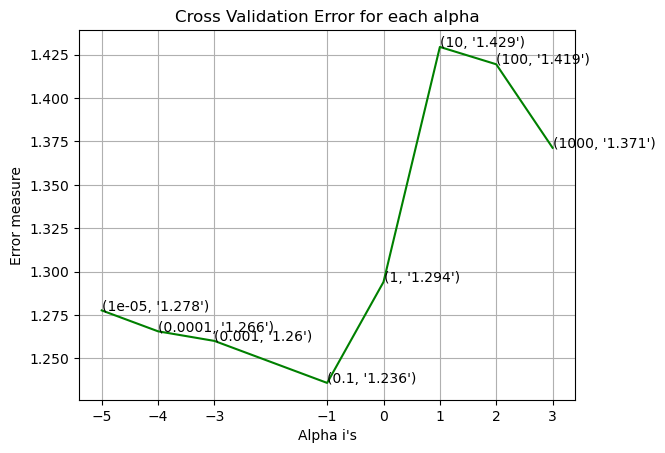

In [62]:
fig, ax = plt.subplots()
## Plotting the log of alpha makes the points much more visible
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [63]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)


predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.1 The train log loss is: 0.8871252750196414
For values of best alpha =  0.1 The cross validation log loss is: 1.2358687795759464
For values of best alpha =  0.1 The test log loss is: 1.27454093764196


#### Testing the model with best hyper paramters

Number of mis-classified points : 0.39849624060150374
-------------------- Confusion matrix --------------------


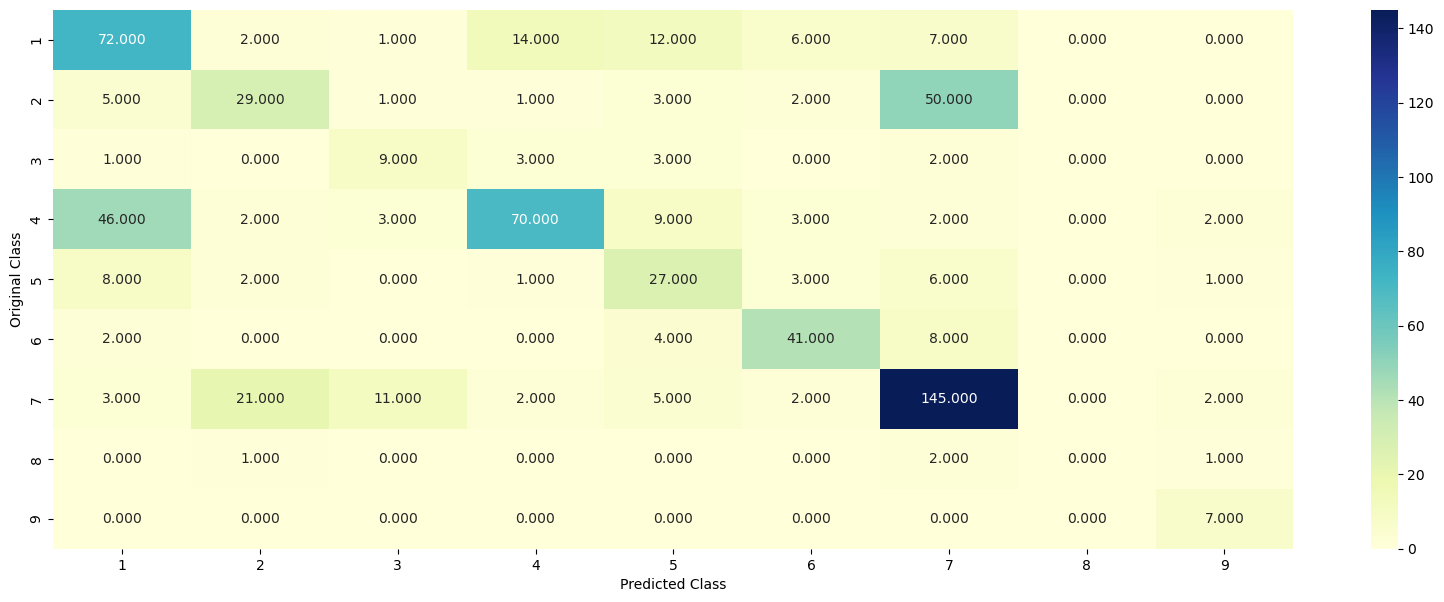

-------------------- Precision matrix (Column Sum=1) --------------------


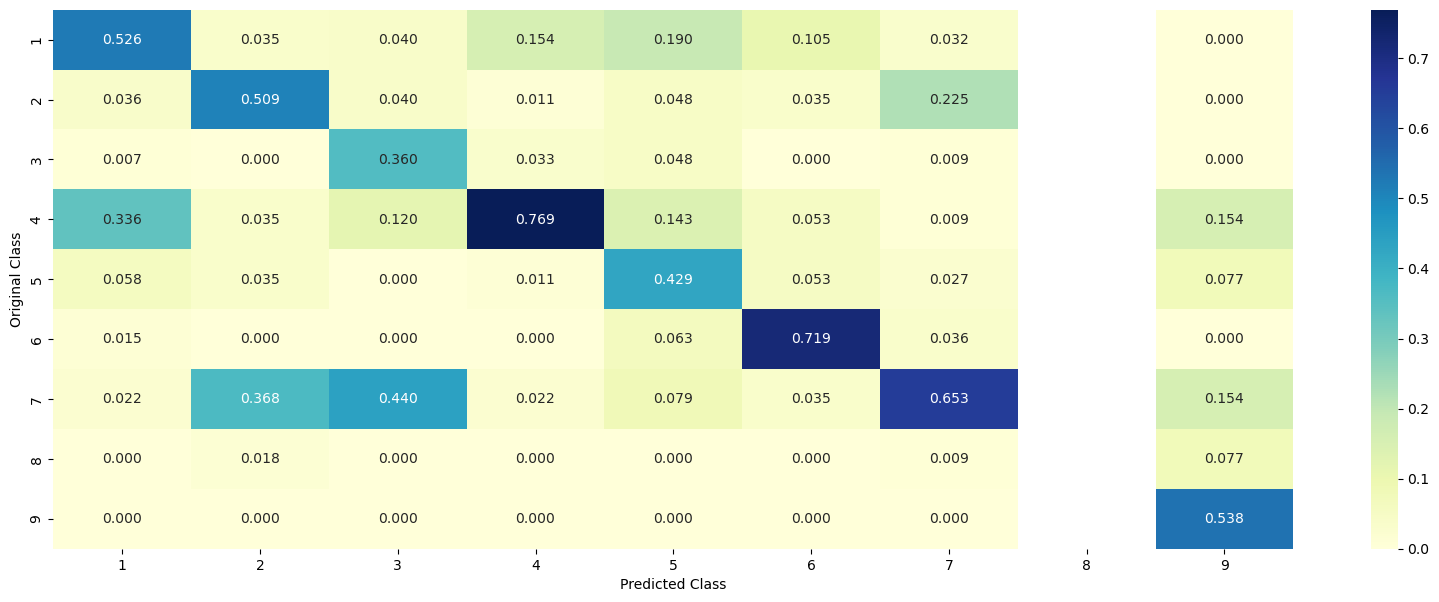

-------------------- Recall matrix (Row sum=1) --------------------


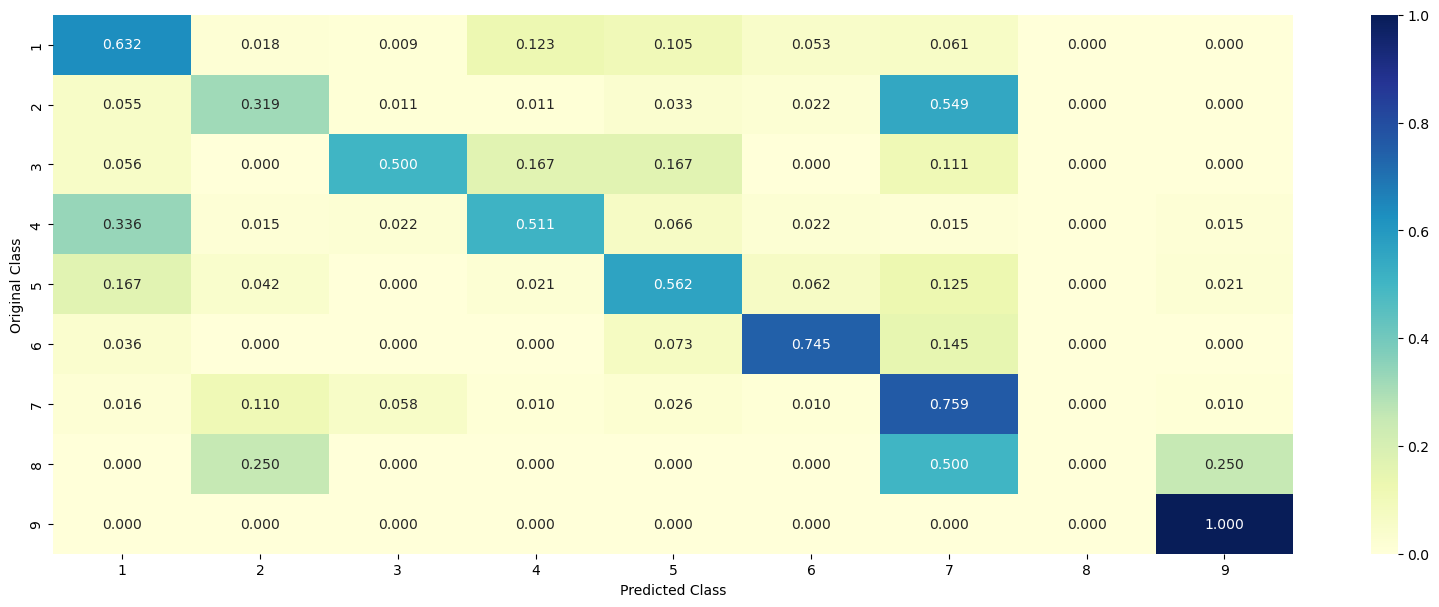

In [64]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

####  Feature Importance (Correctly classified point as an example)

In [65]:
test_point_index = 3  ## Change the index to view for different test points
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.566  0.0781 0.0129 0.1078 0.0401 0.0409 0.1442 0.0055 0.0045]]
Actual Class : 4
--------------------------------------------------
12 Text feature [function] present in test data point
13 Text feature [affect] present in test data point
14 Text feature [type] present in test data point
15 Text feature [protein] present in test data point
16 Text feature [one] present in test data point
17 Text feature [the] present in test data point
18 Text feature [each] present in test data point
19 Text feature [two] present in test data point
20 Text feature [wild] present in test data point
21 Text feature [amino] present in test data point
22 Text feature [remaining] present in test data point
23 Text feature [sequence] present in test data point
24 Text feature [sequences] present in test data point
25 Text feature [binding] present in test data point
26 Text feature [loss] present in test data point
27 Text feature [are] present in test da

####  Feature Importance (Incorrectly classified point as an example)

In [66]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 1
Predicted Class Probabilities: [[0.566  0.0781 0.0129 0.1078 0.0401 0.0409 0.1442 0.0055 0.0045]]
Actual Class : 7
--------------------------------------------------
12 Text feature [function] present in test data point
13 Text feature [affect] present in test data point
14 Text feature [type] present in test data point
15 Text feature [protein] present in test data point
16 Text feature [one] present in test data point
17 Text feature [the] present in test data point
18 Text feature [each] present in test data point
19 Text feature [two] present in test data point
20 Text feature [wild] present in test data point
21 Text feature [amino] present in test data point
22 Text feature [remaining] present in test data point
23 Text feature [sequence] present in test data point
24 Text feature [sequences] present in test data point
25 Text feature [binding] present in test data point
26 Text feature [loss] present in test data point
27 Text feature [are] present in test da

##  Logistic Regression with one-hot encoded features

###  LR With Class balancing

####  Hyper paramter tuning

In [72]:
alpha = [10 ** x for x in range(-6, 3)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(class_weight='balanced', alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

for alpha = 1e-06
Log Loss : 1.3403096131184085
for alpha = 1e-05
Log Loss : 1.3227644934867557
for alpha = 0.0001
Log Loss : 1.1559342643551702
for alpha = 0.001
Log Loss : 1.1305909716960438
for alpha = 0.01
Log Loss : 1.1567792221733095
for alpha = 0.1
Log Loss : 1.4535144663374577
for alpha = 1
Log Loss : 1.6939205035477616
for alpha = 10
Log Loss : 1.7243125827559116
for alpha = 100
Log Loss : 1.7274988761025678


Text(0, 0.5, 'Error measure')

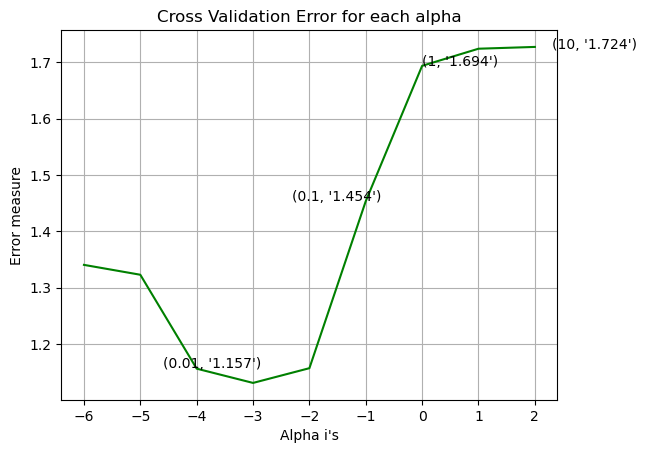

In [73]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [74]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.001 The train log loss is: 0.5292643377656202
For values of best alpha =  0.001 The cross validation log loss is: 1.1210156144806451
For values of best alpha =  0.001 The test log loss is: 1.058199528334973


#### Testing the model with best hyper paramters

Number of mis-classified points : 0.34285714285714286
-------------------- Confusion matrix --------------------


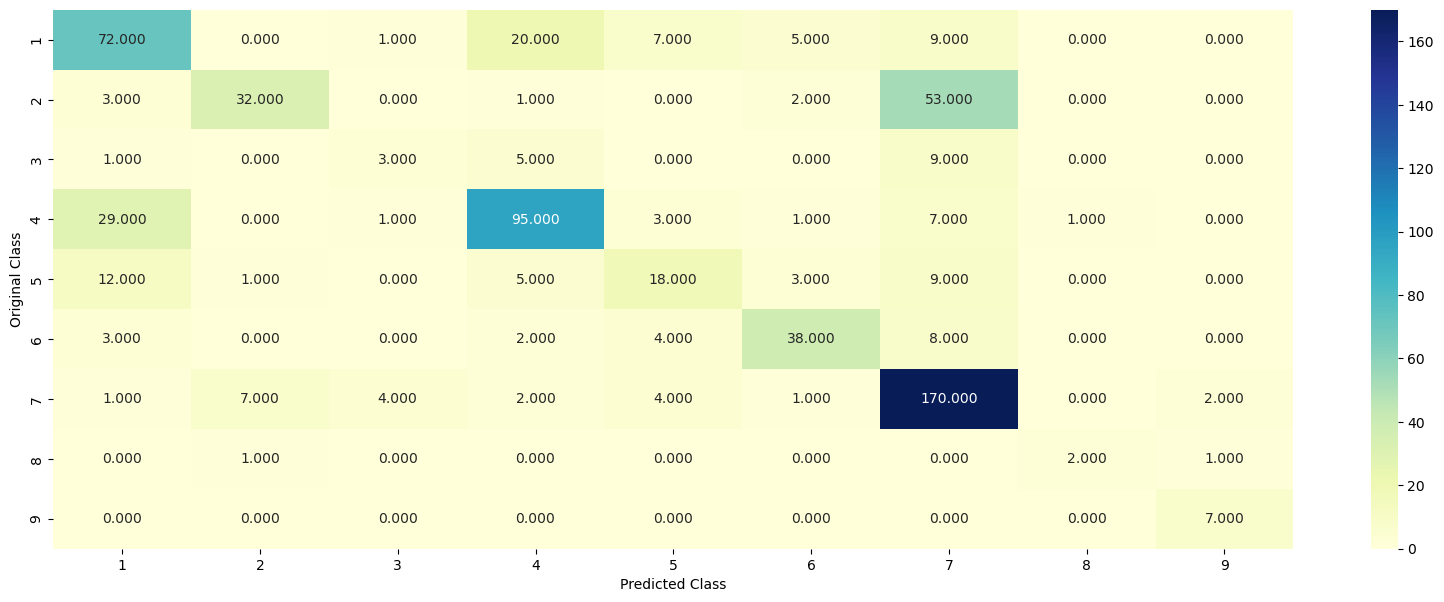

-------------------- Precision matrix (Column Sum=1) --------------------


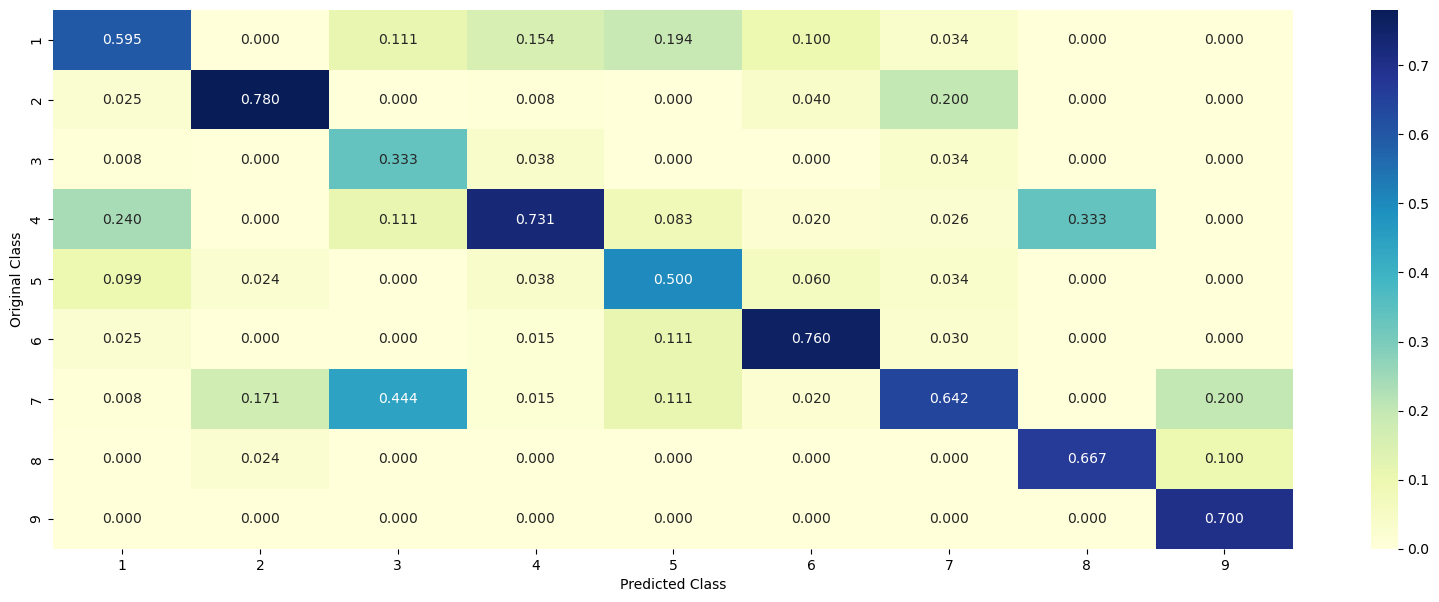

-------------------- Recall matrix (Row sum=1) --------------------


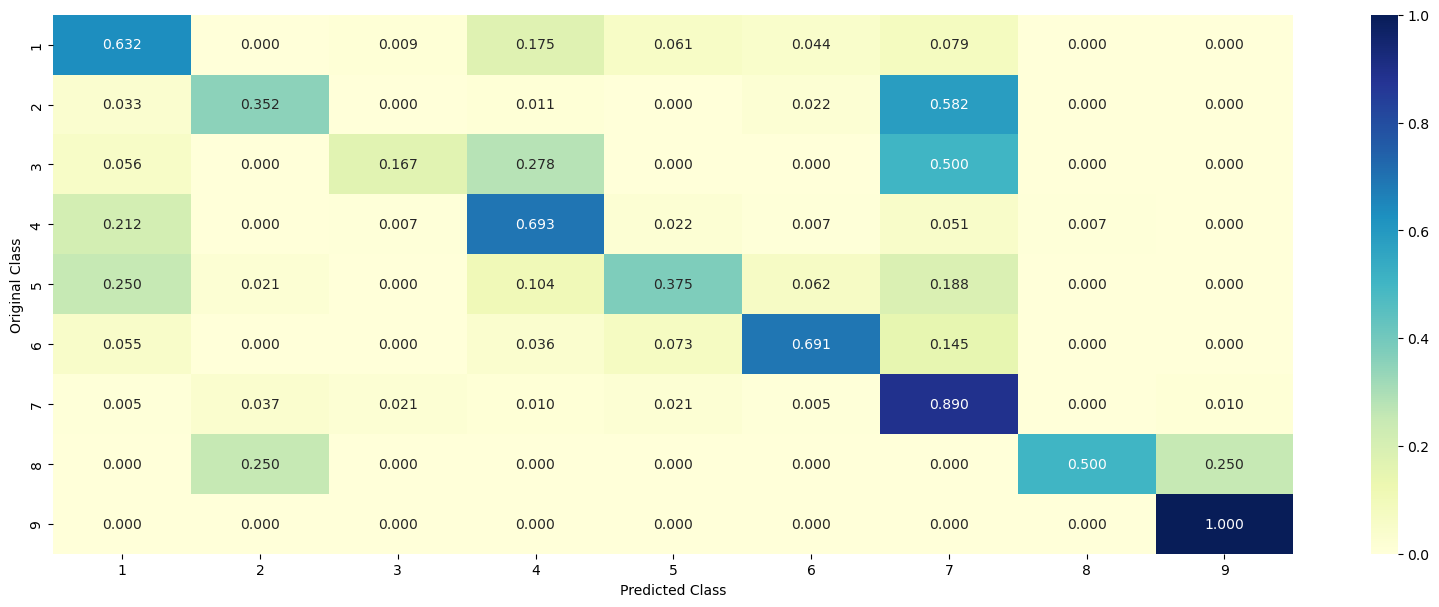

In [75]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

####  Feature Importance

#####  Correctly Classified point

In [76]:
test_point_index = 3
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.3302 0.0396 0.0057 0.4652 0.0131 0.0084 0.1213 0.0125 0.004 ]]
Actual Class : 4
--------------------------------------------------
139 Text feature [adapted] present in test data point
157 Text feature [activating] present in test data point
242 Text feature [suppressor] present in test data point
398 Text feature [strengthen] present in test data point
458 Text feature [harboring] present in test data point
466 Text feature [highest] present in test data point
Out of the top  500  features  6 are present in query point


#####  Incorrectly Classified point

In [77]:
test_point_index = 1
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1519 0.108  0.0071 0.3079 0.0176 0.0099 0.3767 0.0161 0.0048]]
Actual Class : 7
--------------------------------------------------
84 Text feature [nonsense] present in test data point
85 Text feature [missense] present in test data point
143 Text feature [activated] present in test data point
160 Text feature [function] present in test data point
169 Text feature [loss] present in test data point
219 Text feature [frameshift] present in test data point
269 Text feature [activating] present in test data point
272 Text feature [stability] present in test data point
296 Text feature [activation] present in test data point
301 Text feature [remove] present in test data point
316 Text feature [truncating] present in test data point
338 Text feature [oncogene] present in test data point
340 Text feature [predicted] present in test data point
345 Text feature [retained] present in test data point
380 Text feature [affect] present in test

###  LR Without Class balancing

####  Hyper paramter tuning

In [78]:
alpha = [10 ** x for x in range(-6, 1)]
cv_log_error_array = []
for i in alpha:
    print("for alpha =", i)
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log')
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))

for alpha = 1e-06
Log Loss : 1.3160642236539577
for alpha = 1e-05
Log Loss : 1.2984848867016607
for alpha = 0.0001
Log Loss : 1.1843917611182544
for alpha = 0.001
Log Loss : 1.1360470315141507
for alpha = 0.01
Log Loss : 1.2236839686491587
for alpha = 0.1
Log Loss : 1.3419164710951033
for alpha = 1
Log Loss : 1.593759223062468


Text(0, 0.5, 'Error measure')

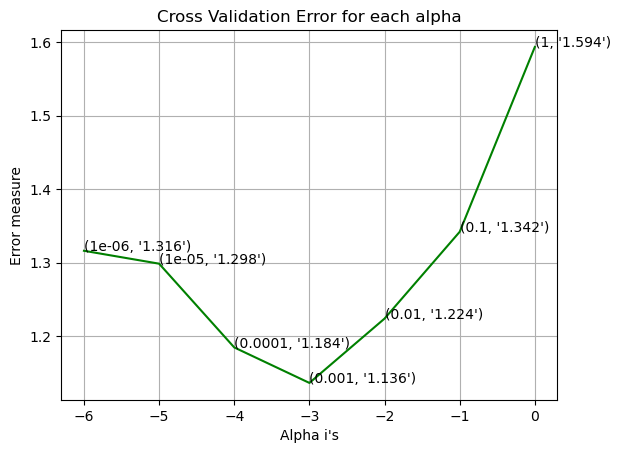

In [79]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xticks(np.log10(alpha))
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [80]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log')
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.001 The train log loss is: 0.5353586402388634
For values of best alpha =  0.001 The cross validation log loss is: 1.1434652681011441
For values of best alpha =  0.001 The test log loss is: 1.076021230068221


####  Testing model with best hyper parameters

Number of mis-classified points : 0.34135338345864663
-------------------- Confusion matrix --------------------


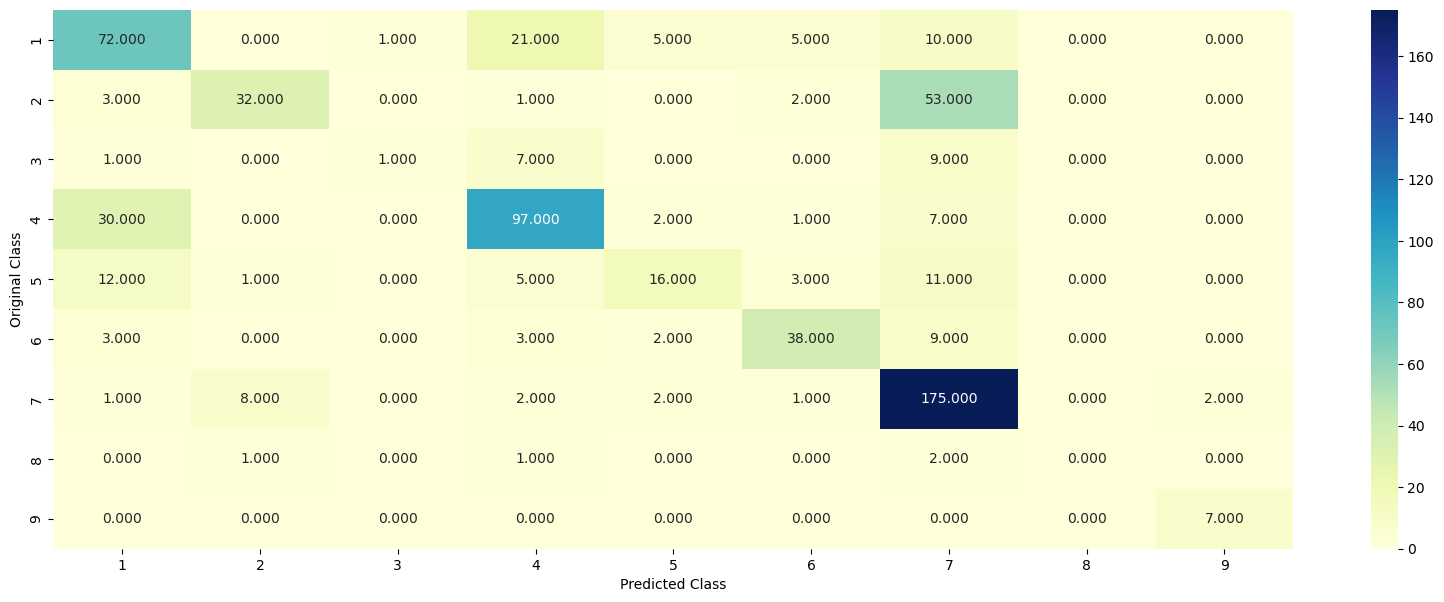

-------------------- Precision matrix (Column Sum=1) --------------------


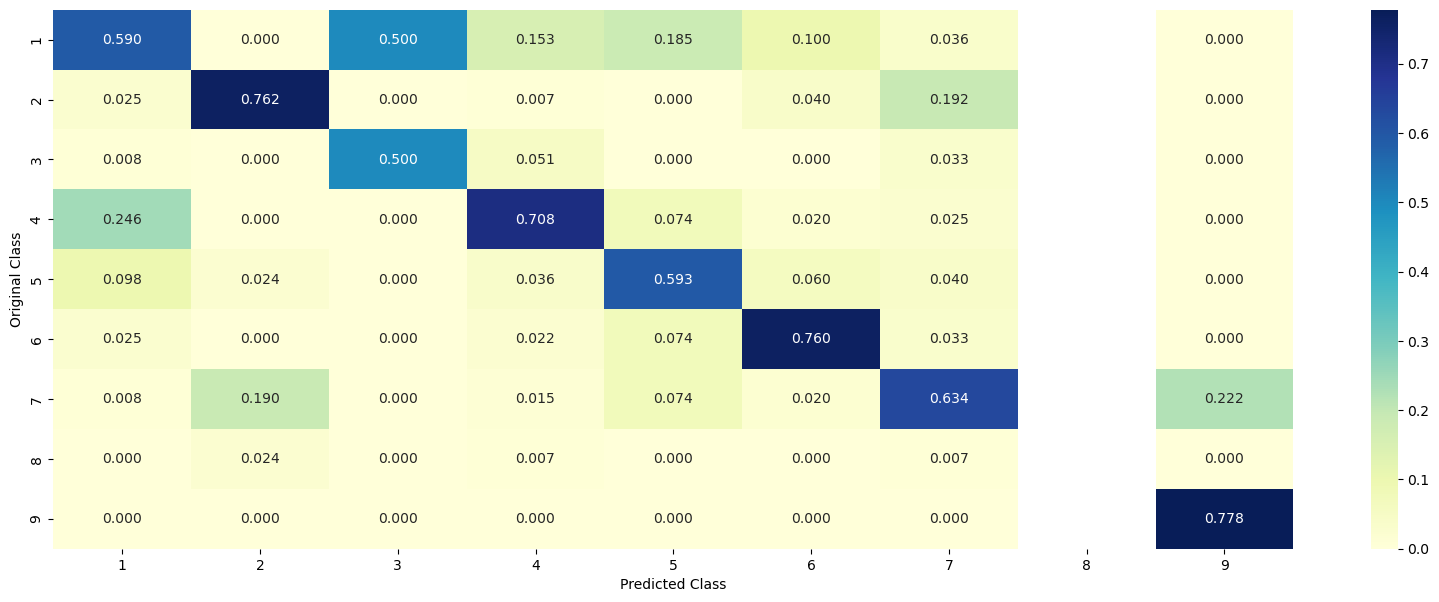

-------------------- Recall matrix (Row sum=1) --------------------


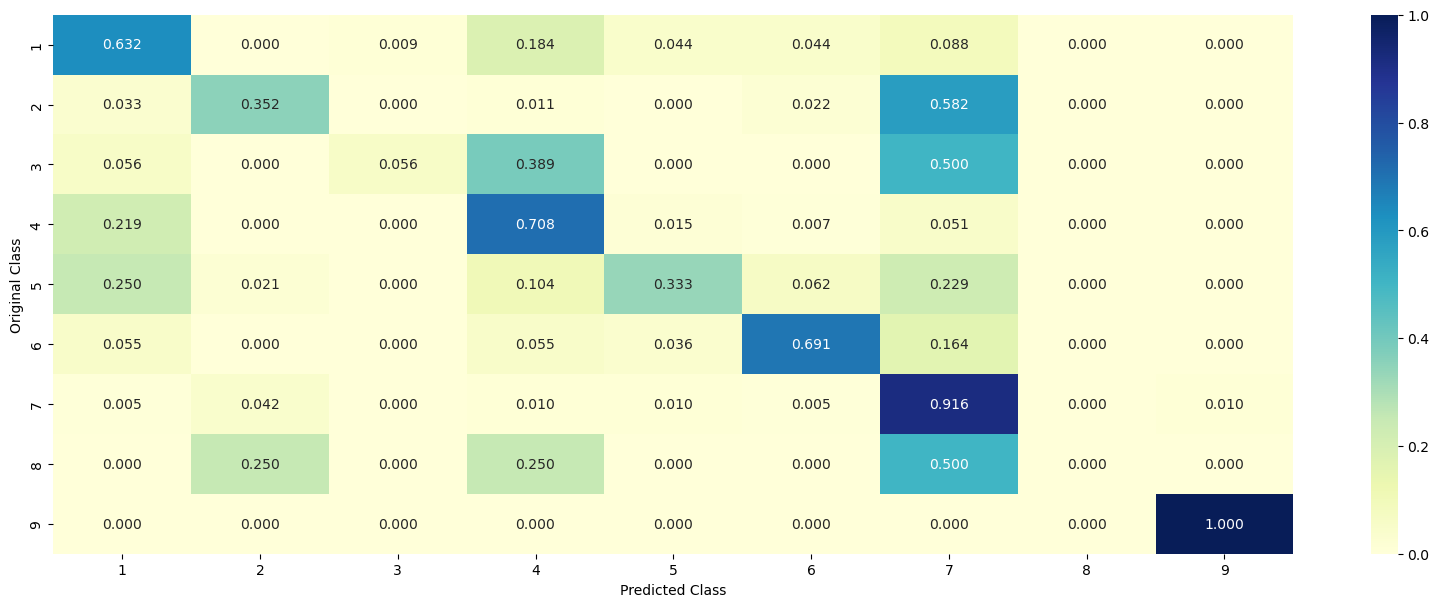

In [81]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

####  Feature Importance, Correctly Classified point

In [82]:
test_point_index = 6
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.0036 0.0118 0.0037 0.0548 0.1454 0.0032 0.7714 0.005  0.0011]]
Actual Class : 7
--------------------------------------------------
71 Text feature [transforming] present in test data point
175 Text feature [nude] present in test data point
226 Text feature [constitutive] present in test data point
262 Text feature [activated] present in test data point
263 Text feature [constitutively] present in test data point
311 Text feature [activating] present in test data point
318 Text feature [missense] present in test data point
410 Text feature [downstream] present in test data point
413 Text feature [receptors] present in test data point
415 Text feature [expressing] present in test data point
463 Text feature [extracellular] present in test data point
467 Text feature [activation] present in test data point
Out of the top  500  features  12 are present in query point


####  Feature Importance, Inorrectly Classified point

In [83]:
test_point_index = 29
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 4
Predicted Class Probabilities: [[0.011  0.0527 0.0342 0.3191 0.0076 0.     0.2821 0.2933 0.    ]]
Actual Class : 4
--------------------------------------------------
277 Text feature [activating] present in test data point
299 Text feature [degrade] present in test data point
302 Text feature [suppressor] present in test data point
311 Text feature [truncate] present in test data point
392 Text feature [microscopy] present in test data point
430 Text feature [chromatogram] present in test data point
460 Text feature [cycloheximide] present in test data point
468 Text feature [localization] present in test data point
486 Text feature [transforming] present in test data point
Out of the top  500  features  9 are present in query point


##  Linear Support Vector Machines

###  Hyper paramter tuning

In [84]:
alpha = [10 ** x for x in range(-5, 3)]
cv_log_error_array = []
for i in alpha:
    print("for C =", i)
    ## Balancing the classes
    clf = SGDClassifier( class_weight='balanced', alpha=i, penalty='l2', loss='hinge')
    clf.fit(train_x_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x_onehotCoding, y_train)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_))
    print("Log Loss :",log_loss(y_cv, sig_clf_probs))

for C = 1e-05
Log Loss : 1.3265354461101457
for C = 0.0001
Log Loss : 1.2606245235953804
for C = 0.001
Log Loss : 1.1683967727455153
for C = 0.01
Log Loss : 1.1479185614389005
for C = 0.1
Log Loss : 1.3874704264654976
for C = 1
Log Loss : 1.708584659243074
for C = 10
Log Loss : 1.7280540893169871
for C = 100
Log Loss : 1.7280510187098117


Text(0, 0.5, 'Error measure')

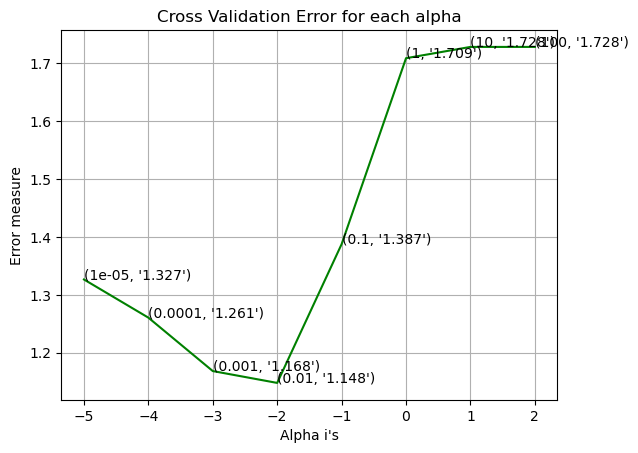

In [85]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha), cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.xticks(np.log10(alpha))
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")

In [86]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(class_weight='balanced', alpha=alpha[best_alpha], penalty='l2', loss='hinge')
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best alpha =  0.01 The train log loss is: 0.7439484738576452
For values of best alpha =  0.01 The cross validation log loss is: 1.146889929302327
For values of best alpha =  0.01 The test log loss is: 1.104321821403874


###  Testing model with best hyper parameters

Number of mis-classified points : 0.3548872180451128
-------------------- Confusion matrix --------------------


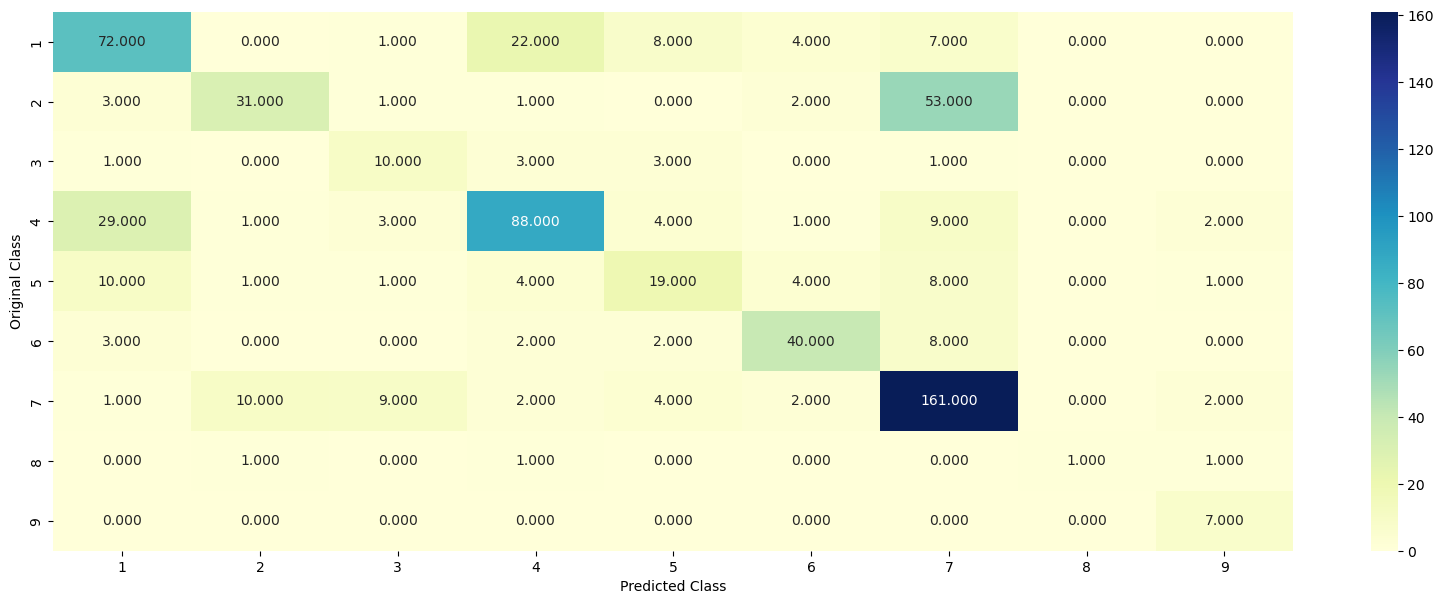

-------------------- Precision matrix (Column Sum=1) --------------------


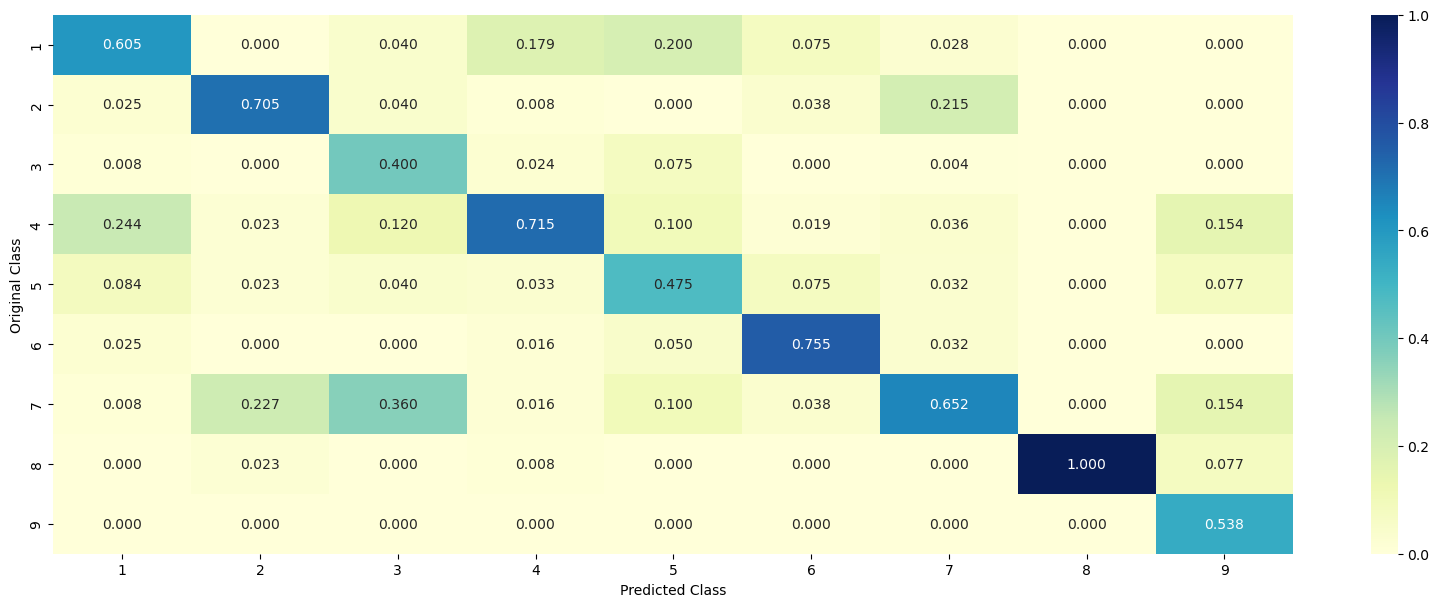

-------------------- Recall matrix (Row sum=1) --------------------


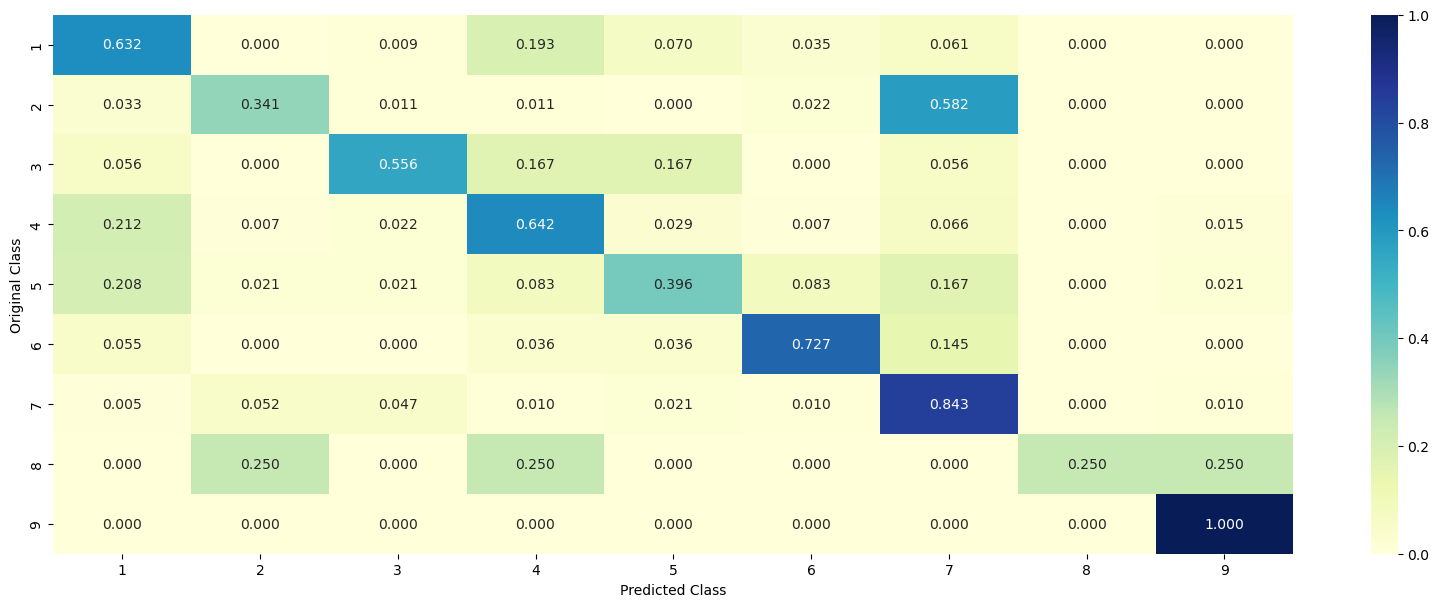

In [87]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

###  Feature Importance

####  For Correctly classified point

In [88]:
test_point_index = 2
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 9
Predicted Class Probabilities: [[5.960e-02 2.230e-02 7.000e-04 3.940e-02 2.490e-02 6.900e-03 8.600e-02
  6.000e-03 7.543e-01]]
Actual Class : 9
--------------------------------------------------
150 Text feature [enantiomers] present in test data point
151 Text feature [metabolites] present in test data point
195 Text feature [global] present in test data point
199 Text feature [oncometabolite] present in test data point
203 Text feature [trimethylation] present in test data point
205 Text feature [methyltransferases] present in test data point
212 Text feature [cartilaginous] present in test data point
239 Text feature [enantiomer] present in test data point
246 Text feature [formic] present in test data point
259 Text feature [demethylases] present in test data point
260 Text feature [utilization] present in test data point
270 Text feature [chirality] present in test data point
275 Text feature [metabolite] present in test data point
281 Text feature [derivatized

####  For Incorrectly classified point

In [89]:
test_point_index = 14
no_feature = 500
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-abs(clf.coef_))[predicted_cls-1][:no_feature]
print("-"*50)
get_impfeature_names(indices, test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 3
Predicted Class Probabilities: [[0.04   0.0437 0.5837 0.2078 0.0343 0.0211 0.0614 0.0054 0.0026]]
Actual Class : 4
--------------------------------------------------
Out of the top  500  features  0 are present in query point


##  Random Forest Classifier with one hot encoded features

###  Hyper paramter tuning

In [90]:
alpha = [100,200,500,1000,2000]   ## May try other values
max_depth = [5, 10]          ## May try other values
cv_log_error_array = []
for i in alpha:
    for j in max_depth:
        print("for n_estimators =", i,"and max depth = ", j)
        clf = RandomForestClassifier(n_estimators=i, criterion='gini', max_depth=j, random_state=42, n_jobs=-1)
        clf.fit(train_x_onehotCoding, y_train)
        sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
        sig_clf.fit(train_x_onehotCoding, y_train)
        sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
        cv_log_error_array.append(log_loss(y_cv, sig_clf_probs, labels=clf.classes_, eps=1e-15))
        print("Log Loss :",log_loss(y_cv, sig_clf_probs)) 

for n_estimators = 100 and max depth =  5
Log Loss : 1.2636917821272253
for n_estimators = 100 and max depth =  10
Log Loss : 1.1885494304403297
for n_estimators = 200 and max depth =  5
Log Loss : 1.2479950625396368
for n_estimators = 200 and max depth =  10
Log Loss : 1.18711570876359
for n_estimators = 500 and max depth =  5
Log Loss : 1.2454301095840248
for n_estimators = 500 and max depth =  10
Log Loss : 1.1830722909786129
for n_estimators = 1000 and max depth =  5
Log Loss : 1.2430058123705332
for n_estimators = 1000 and max depth =  10
Log Loss : 1.1841000057752231
for n_estimators = 2000 and max depth =  5
Log Loss : 1.2386462543628338
for n_estimators = 2000 and max depth =  10
Log Loss : 1.182410007985698


In [91]:
best_alpha = np.argmin(cv_log_error_array)
clf = RandomForestClassifier(n_estimators=alpha[int(best_alpha/2)], criterion='gini', max_depth=max_depth[int(best_alpha%2)], n_jobs=-1)
clf.fit(train_x_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_x_onehotCoding, y_train)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best estimator = ', alpha[int(best_alpha/2)], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_))

For values of best estimator =  2000 The train log loss is: 0.690445658837232
For values of best estimator =  2000 The cross validation log loss is: 1.181760584233699
For values of best estimator =  2000 The test log loss is: 1.1389629333999414


###  Testing model with best hyper parameters (One Hot Encoding)

Number of mis-classified points : 0.4030075187969925
-------------------- Confusion matrix --------------------


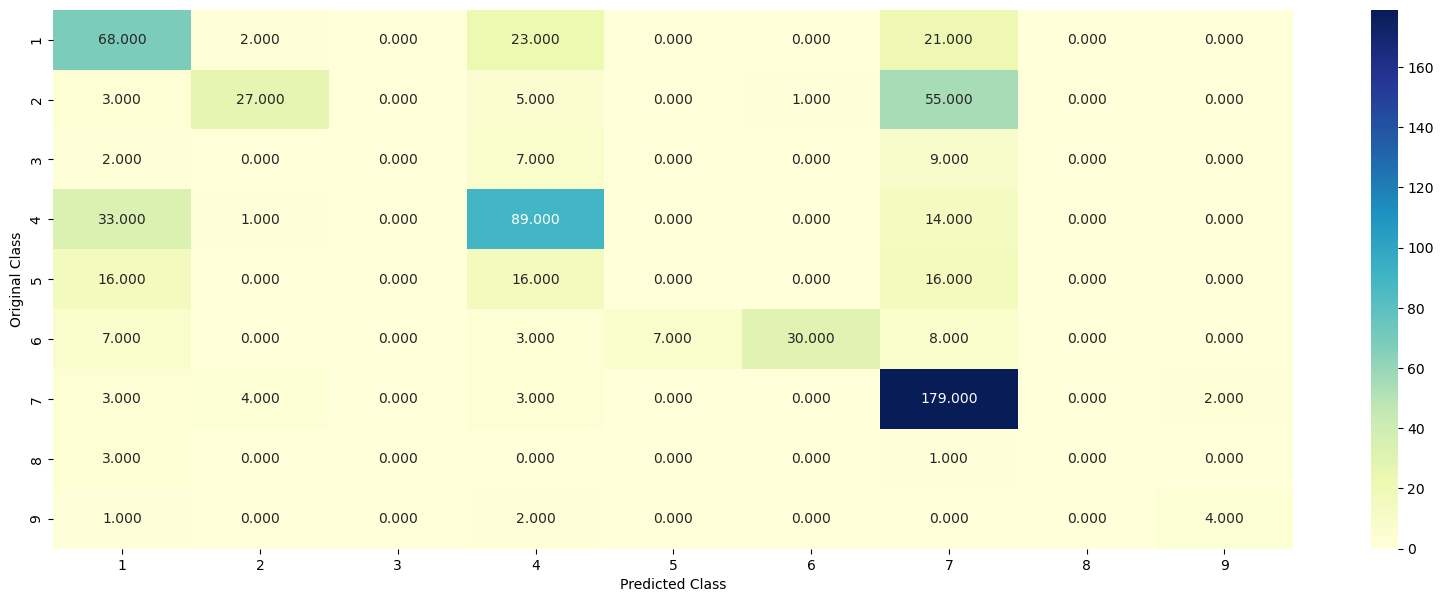

-------------------- Precision matrix (Column Sum=1) --------------------


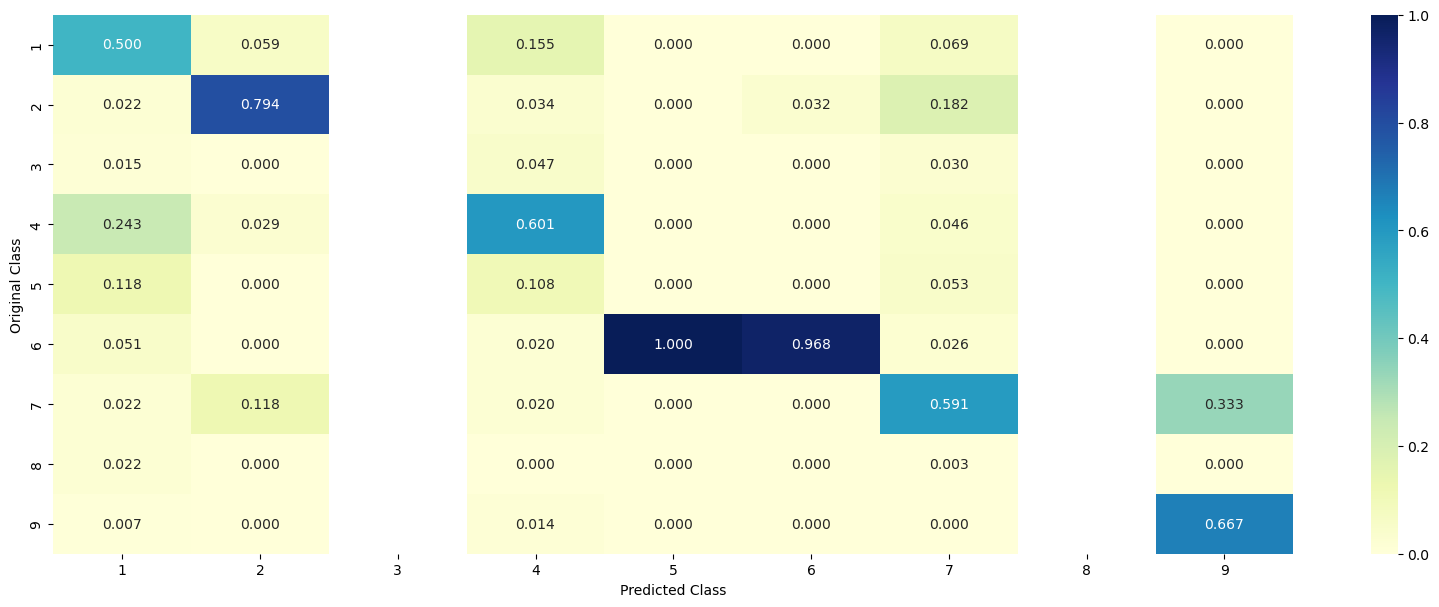

-------------------- Recall matrix (Row sum=1) --------------------


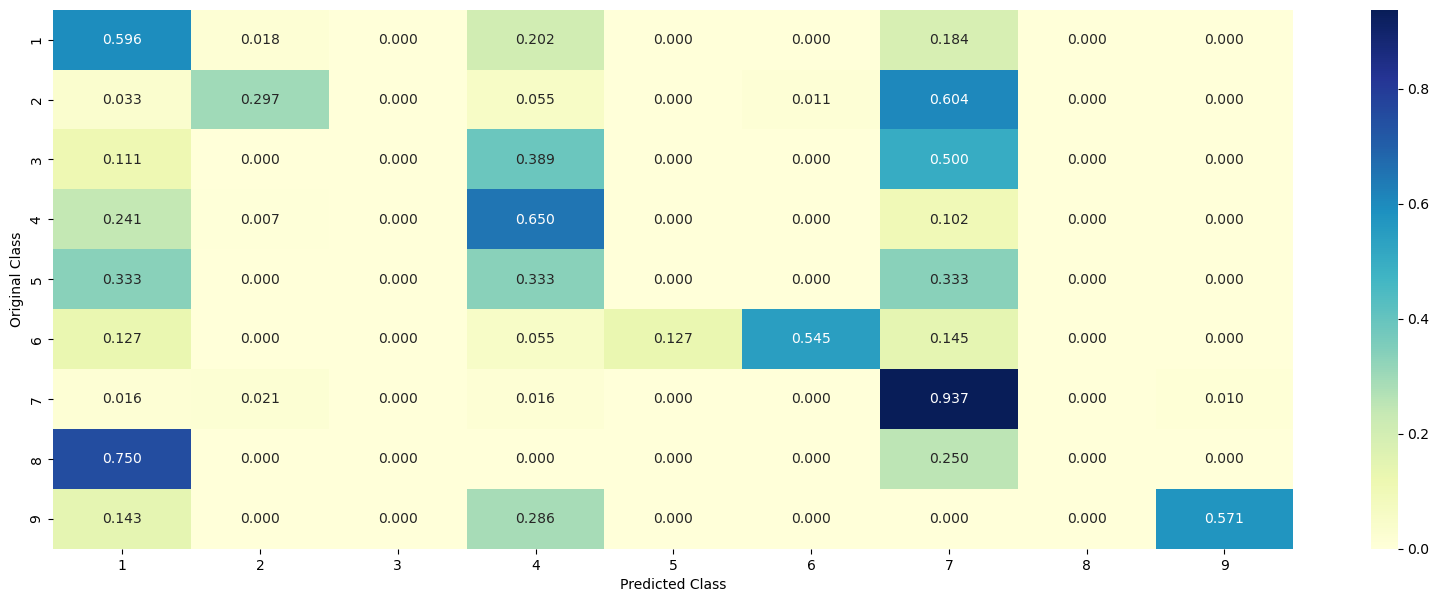

In [92]:
pred_y = sig_clf.predict(test_x_onehotCoding)
# calculating the number of data points that are misclassified
print("Number of mis-classified points :", np.count_nonzero((pred_y - y_test))/y_test.shape[0])
plot_confusion_matrix(y_test,pred_y)

###  Feature Importance

####  Correctly Classified point

In [93]:
test_point_index = 3
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.2481 0.1155 0.0225 0.199  0.0598 0.0508 0.2816 0.0101 0.0126]]
Actual Class : 4
--------------------------------------------------
1 Text feature [activating] present in test data point
3 Text feature [activation] present in test data point
4 Text feature [function] present in test data point
5 Text feature [missense] present in test data point
7 Text feature [activated] present in test data point
8 Text feature [suppressor] present in test data point
10 Text feature [oncogenic] present in test data point
12 Text feature [treatment] present in test data point
13 Text feature [loss] present in test data point
14 Text feature [signaling] present in test data point
16 Text feature [inhibitor] present in test data point
23 Text feature [cells] present in test data point
26 Text feature [constitutively] present in test data point
30 Text feature [drug] present in test data point
36 Text feature [inhibition] present in test data point
38

####  Inorrectly Classified point

In [94]:
test_point_index = 12
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])[0]
print("Predicted Class :", predicted_cls)
print("Predicted Class Probabilities:", np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print("Actual Class :", y_test[test_point_index])
indices = np.argsort(-clf.feature_importances_)
print("-"*50)
get_impfeature_names(indices[:no_feature], test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index], no_feature)

Predicted Class : 7
Predicted Class Probabilities: [[0.1711 0.1187 0.0282 0.2238 0.0677 0.0588 0.3119 0.0096 0.0102]]
Actual Class : 1
--------------------------------------------------
1 Text feature [activating] present in test data point
3 Text feature [activation] present in test data point
4 Text feature [function] present in test data point
5 Text feature [missense] present in test data point
7 Text feature [activated] present in test data point
8 Text feature [suppressor] present in test data point
10 Text feature [oncogenic] present in test data point
13 Text feature [loss] present in test data point
14 Text feature [signaling] present in test data point
22 Text feature [phosphorylation] present in test data point
23 Text feature [cells] present in test data point
27 Text feature [functional] present in test data point
39 Text feature [growth] present in test data point
42 Text feature [proliferation] present in test data point
43 Text feature [defective] present in test data p

##  Stacking models

###  Hyper parameter tuning

**Note:** The optimal values of the hyper parameters of the base learners is taken from the individual models built above. Here we only do the hyperparameter tuning for the meta classifier

In [95]:
## clf1 is logistic regression with balanced classes
clf1 = SGDClassifier(alpha=0.001, penalty='l2', loss='log', class_weight='balanced', random_state=0)
clf1.fit(train_x_onehotCoding, y_train)
sig_clf1 = CalibratedClassifierCV(clf1, method="sigmoid")

## clf2 is SVM with balanced classes
clf2 = SGDClassifier(alpha=0.01, penalty='l2', loss='hinge', class_weight='balanced', random_state=0)
clf2.fit(train_x_onehotCoding, y_train)
sig_clf2 = CalibratedClassifierCV(clf2, method="sigmoid")

## clf3 is Naive Bayes Model
clf3 = MultinomialNB(alpha=0.1)
clf3.fit(train_x_onehotCoding, y_train)
sig_clf3 = CalibratedClassifierCV(clf3, method="sigmoid")

sig_clf1.fit(train_x_onehotCoding, y_train)
print("Logistic Regression :  Log Loss: %0.2f" % (log_loss(y_cv, sig_clf1.predict_proba(cv_x_onehotCoding))))
sig_clf2.fit(train_x_onehotCoding, y_train)
print("Support vector machines : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf2.predict_proba(cv_x_onehotCoding))))
sig_clf3.fit(train_x_onehotCoding, y_train)
print("Naive Bayes : Log Loss: %0.2f" % (log_loss(y_cv, sig_clf3.predict_proba(cv_x_onehotCoding))))
print("-"*50)
alpha = [0.0001,0.001,0.01,0.1,1,10] 
min_error = 999
## Meta Classifier is Logistic Regression
for i in alpha:
    lr = LogisticRegression(C=i)
    sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
    sclf.fit(train_x_onehotCoding, y_train)
    print("Stacking Classifer : for the value of alpha: %f Log Loss: %0.3f" % (i, log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))))
    log_error =log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))
    if min_error > log_error:
        min_error = log_error
        best_alpha = i

Logistic Regression :  Log Loss: 1.12
Support vector machines : Log Loss: 1.14
Naive Bayes : Log Loss: 1.24
--------------------------------------------------
Stacking Classifer : for the value of alpha: 0.000100 Log Loss: 1.813
Stacking Classifer : for the value of alpha: 0.001000 Log Loss: 1.686
Stacking Classifer : for the value of alpha: 0.010000 Log Loss: 1.279
Stacking Classifer : for the value of alpha: 0.100000 Log Loss: 1.198
Stacking Classifer : for the value of alpha: 1.000000 Log Loss: 1.450
Stacking Classifer : for the value of alpha: 10.000000 Log Loss: 1.821


###  Testing the model with the best hyper parameters

Log loss (train) on the stacking classifier : 0.4948693395268743
Log loss (CV) on the stacking classifier : 1.1980588681179414
Log loss (test) on the stacking classifier : 1.1718128613173133
Number of missclassified point : 0.3533834586466165
-------------------- Confusion matrix --------------------


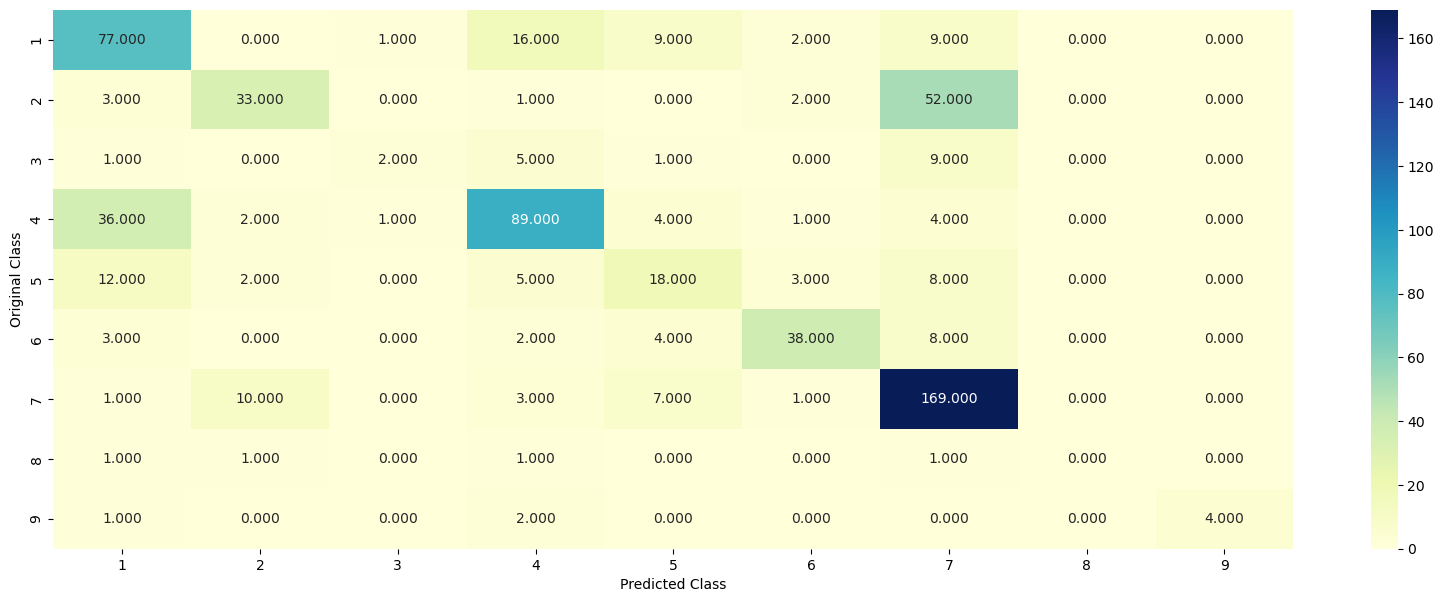

-------------------- Precision matrix (Column Sum=1) --------------------


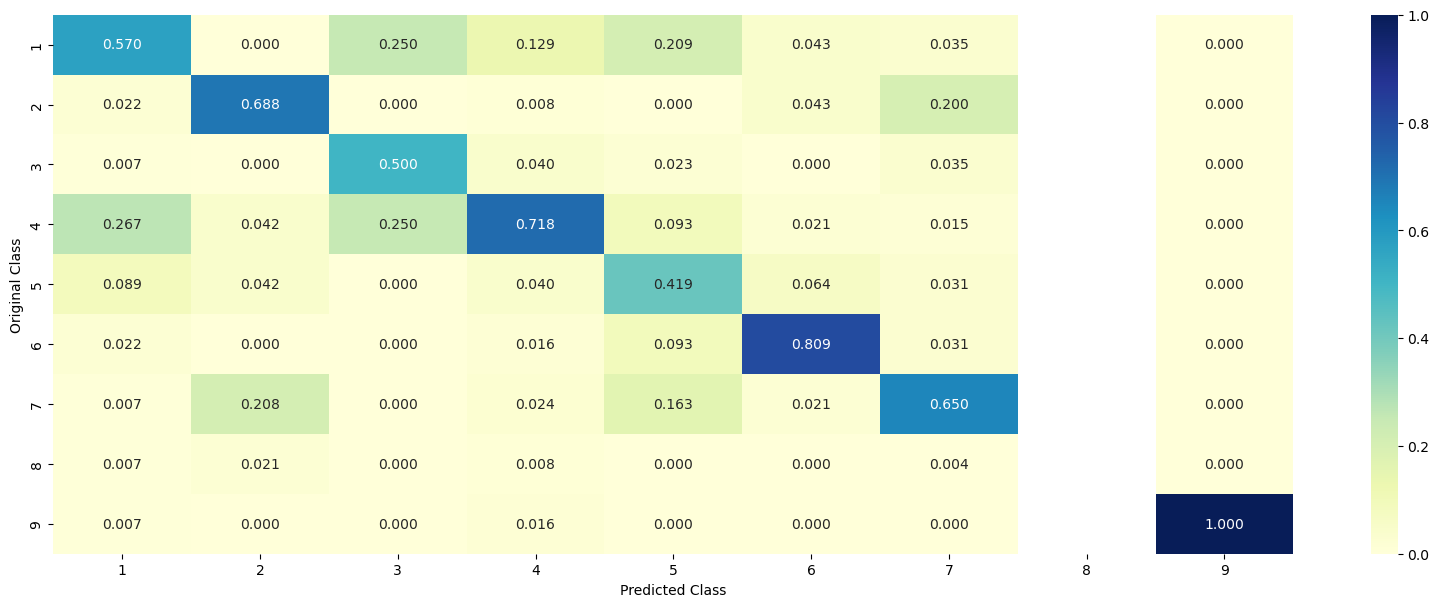

-------------------- Recall matrix (Row sum=1) --------------------


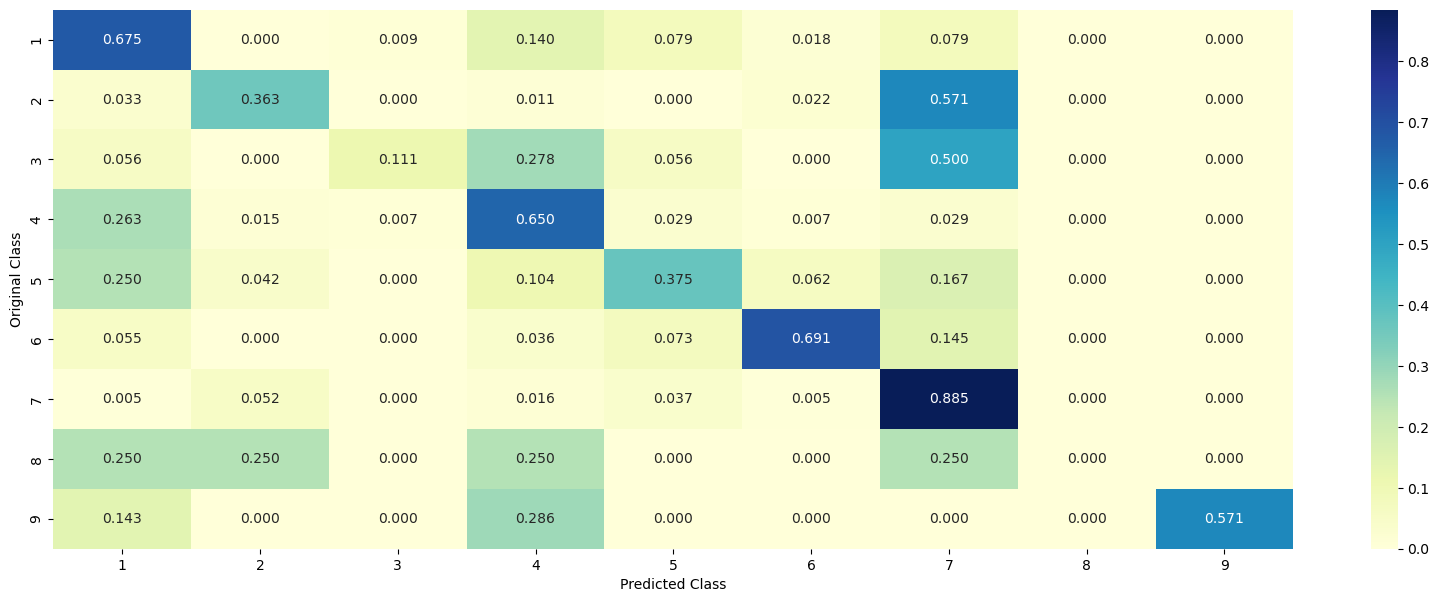

In [96]:
lr = LogisticRegression(C=best_alpha)
sclf = StackingClassifier(classifiers=[sig_clf1, sig_clf2, sig_clf3], meta_classifier=lr, use_probas=True)
sclf.fit(train_x_onehotCoding, y_train)

log_error = log_loss(y_train, sclf.predict_proba(train_x_onehotCoding))
print("Log loss (train) on the stacking classifier :",log_error)

log_error = log_loss(y_cv, sclf.predict_proba(cv_x_onehotCoding))
print("Log loss (CV) on the stacking classifier :",log_error)

log_error = log_loss(y_test, sclf.predict_proba(test_x_onehotCoding))
print("Log loss (test) on the stacking classifier :",log_error)

print("Number of missclassified point :", np.count_nonzero((sclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, sclf.predict(test_x_onehotCoding))

In [99]:
len1,len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100, 3), "% Test accuracy")
len1,len2 = get_intersec_text(cv_df)
print(np.round((len2/len1)*100, 3), "% cross-validation")

96.577 % Test accuracy 
97.986 % cross-validation


###  Maximum Voting classifier
This is another type of Ensemble method which takes in multiple base learners and the meta-classifier is nothing but the majority vote of all the base learners

Log loss (train) on the VotingClassifier : 0.6854450245290423
Log loss (CV) on the VotingClassifier : 1.0759083885009317
Log loss (test) on the VotingClassifier : 1.071471206787117
Number of missclassified point : 0.35639097744360904
-------------------- Confusion matrix --------------------


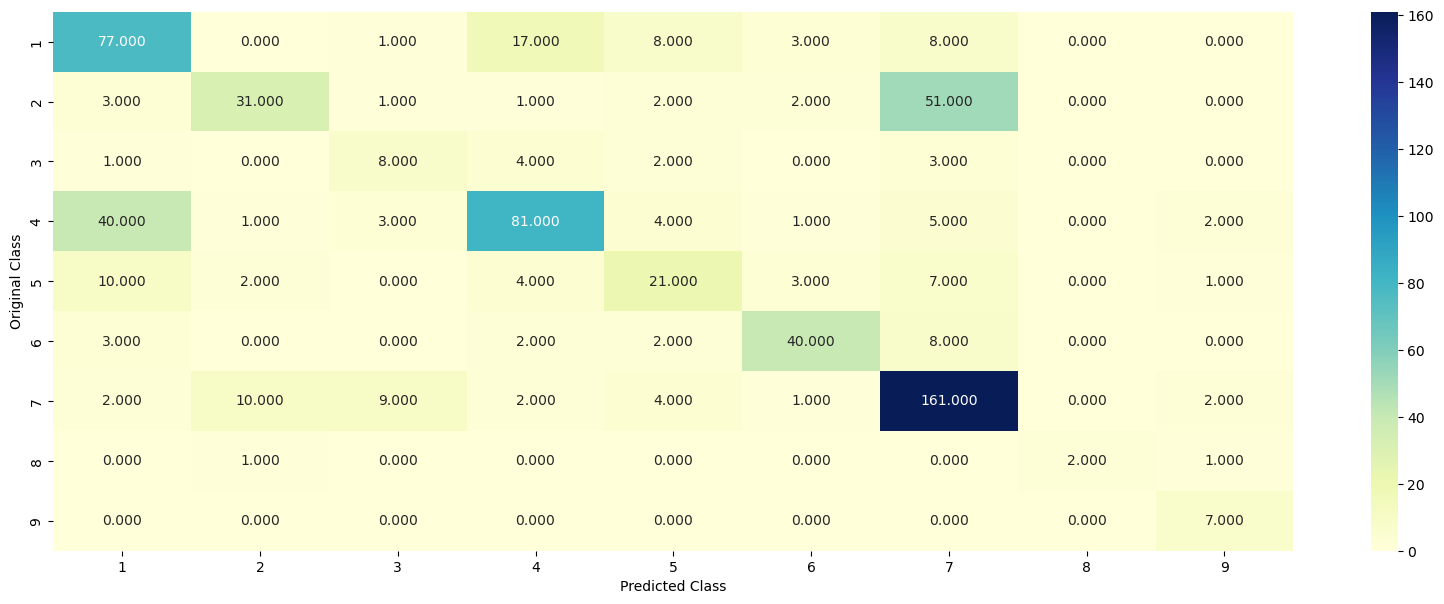

-------------------- Precision matrix (Column Sum=1) --------------------


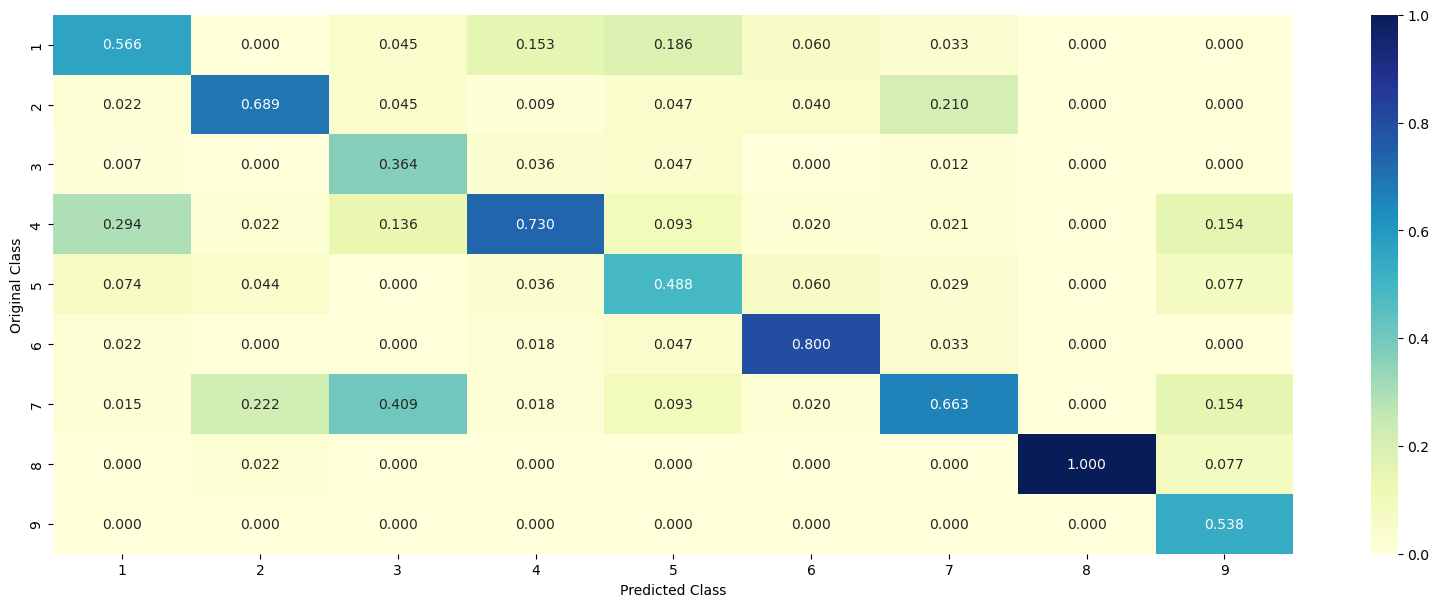

-------------------- Recall matrix (Row sum=1) --------------------


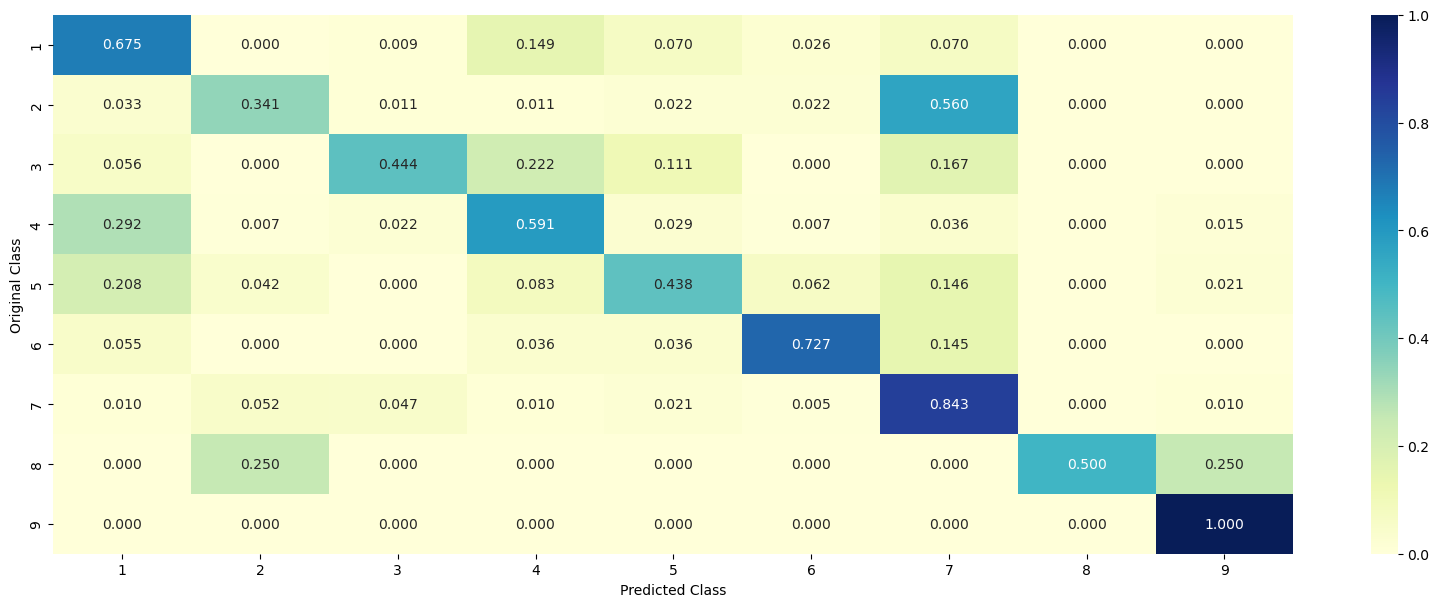

In [97]:
vclf = VotingClassifier(estimators=[('lr', sig_clf1), ('svc', sig_clf2), ('nb', sig_clf3)], voting='soft')
vclf.fit(train_x_onehotCoding, y_train)
print("Log loss (train) on the VotingClassifier :", log_loss(y_train, vclf.predict_proba(train_x_onehotCoding)))
print("Log loss (CV) on the VotingClassifier :", log_loss(y_cv, vclf.predict_proba(cv_x_onehotCoding)))
print("Log loss (test) on the VotingClassifier :", log_loss(y_test, vclf.predict_proba(test_x_onehotCoding)))
print("Number of missclassified point :", np.count_nonzero((vclf.predict(test_x_onehotCoding)- y_test))/y_test.shape[0])
plot_confusion_matrix(y_test, vclf.predict(test_x_onehotCoding))